In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from tqdm.auto import tqdm
import itertools
import matplotlib as mpl
import scipy
# from scipy.integrate import cumtrapz
import seaborn as sns
import os
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import re

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import jax.random as random
import arviz as az

import chart_studio.plotly as py
import chart_studio
import json

import rpgf3lib

warnings.simplefilter(action='ignore', category=UserWarning)

/home/kiran/code/fil-retropgf/rpgf3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
QUORUM = 4
TOTAL_FUNDING = 510000
MIN_FUNDING = 500
SCORING_FN = 'sum'

In [4]:
# Normalize Project Names: use the best version (without replacement characters) for each Application ID
df = pd.read_csv('../data/ballots-fil-retropgf-3-deidentified-cleaned.csv')

# First, normalize whitespace and special characters
df['Project Name Normalized'] = (
    df['Project Name']
    .str.strip()
    .str.replace('–', '-', regex=False)
    .str.replace('\'', "'", regex=False)
)

# Create a mapping: for each Application ID, use the first Project Name that doesn't contain
# If all contain, use the first one
def get_canonical_name(group):
    # Prefer names without replacement character
    without_replacement = group[~group['Project Name Normalized'].str.contains('', na=False)]
    if len(without_replacement) > 0:
        return without_replacement.iloc[0]['Project Name Normalized']
    else:
        return group.iloc[0]['Project Name Normalized']

canonical_names = df.groupby('Application ID').apply(get_canonical_name).to_dict()

# Apply the canonical name to all rows
df['Project Name Canonical'] = df['Application ID'].map(canonical_names)

# Verify: check if there are still conflicts after using canonical names
app_id_groups = df.groupby('Application ID')['Project Name Canonical'].nunique()
conflicting = app_id_groups[app_id_groups > 1].index

if len(conflicting) > 0:
    print("Still have conflicts after canonicalization:")
    display(df[df['Application ID'].isin(conflicting)][['Application ID', 'Project Name', 'Project Name Canonical']].drop_duplicates())
else:
    print(f"✓ Successfully normalized: {len(canonical_names)} unique Application IDs")
    print(f"✓ All Application IDs now have unique canonical Project Names")

✓ Successfully normalized: 120 unique Application IDs
✓ All Application IDs now have unique canonical Project Names


/tmp/ipykernel_446060/403949210.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  canonical_names = df.groupby('Application ID').apply(get_canonical_name).to_dict()


In [5]:
df

,Voter Wallet Address,Application ID,Project Name,Assigned votes,Project Name Normalized,Project Name Canonical
0,Badgeholder 1,1f64b8a1-bdbe-4068-8711-603b6624fb58,Forest,25000,Forest,Forest
1,Badgeholder 1,28288464-b209-4206-84ac-d3d47b340169,Spacescope: API service for the Filecoin ecosy...,30000,Spacescope: API service for the Filecoin ecosy...,Spacescope: API service for the Filecoin ecosy...
2,Badgeholder 1,2bd98798-00fc-4ee2-846b-543627dfae0c,Beryx Filecoin API,20000,Beryx Filecoin API,Beryx Filecoin API
3,Badgeholder 1,32c9890d-111f-4652-92ae-4d538018f11c,Secured Finance,60000,Secured Finance,Secured Finance
4,Badgeholder 1,4499d1d8-a659-41f0-a8ee-845813d3c316,Blockscout Open Source Filecoin Explorer,20000,Blockscout Open Source Filecoin Explorer,Blockscout Open Source Filecoin Explorer
...,...,...,...,...,...,...
945,Badgeholder 30,940de67a-f153-4633-8193-27952a1ac9e3,Ancients Research,4895,Ancients Research,Ancients Research
946,Badgeholder 30,7a4f6567-20bf-4ae0-a918-b79ab5ce1758,Multichain Storage,3969,Multichain Storage,Multichain Storage
947,Badgeholder 30,1855e0c8-6176-4492-9966-535738b38084,Cuview,5821,Cuview,Cuview
948,Badgeholder 30,59c4afee-5d3c-4c21-9977-4d0b88406bd2,Cyberport Data Integration,2740,Cyberport Data Integration,Cyberport Data Integration


In [6]:
NUM_VOTERS = df['Voter Wallet Address'].nunique()
print(f'Number of voters: {NUM_VOTERS}')


Number of voters: 30


In [7]:
dff = df[['Voter Wallet Address', 'Application ID', 'Project Name Canonical', 'Assigned votes']]
dff.rename(columns={
    'Voter Wallet Address': 'voterId',
    'Application ID': 'projectId', 
    'Project Name Canonical': 'project',
    'Assigned votes': 'amount'
    }, 
inplace=True)
dff.head()

# dff.to_csv('../data/project_names.csv', index=False)


/tmp/ipykernel_446060/3305430997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.rename(columns={


,voterId,projectId,project,amount
0,Badgeholder 1,1f64b8a1-bdbe-4068-8711-603b6624fb58,Forest,25000
1,Badgeholder 1,28288464-b209-4206-84ac-d3d47b340169,Spacescope: API service for the Filecoin ecosy...,30000
2,Badgeholder 1,2bd98798-00fc-4ee2-846b-543627dfae0c,Beryx Filecoin API,20000
3,Badgeholder 1,32c9890d-111f-4652-92ae-4d538018f11c,Secured Finance,60000
4,Badgeholder 1,4499d1d8-a659-41f0-a8ee-845813d3c316,Blockscout Open Source Filecoin Explorer,20000


In [8]:
category_df = pd.read_csv('../data/project2cat.csv')
category_df.rename(columns={
    'Project Name': 'project',
    'Category Name': 'impactCategory'}, 
inplace=True)
category_df = category_df[['project', 'impactCategory']]

# Normalize project names in category_df the same way as in the ballots
# Use Unicode escapes for special characters to avoid parsing issues
en_dash = '\u2013'  # en dash
right_single_quote = '\u2019'  # right single quotation mark
category_df['project_normalized'] = (
    category_df['project']
    .str.strip()
    .str.replace(en_dash, '-', regex=False)
    .str.replace(right_single_quote, "'", regex=False)
)

# Create a mapping from normalized names to canonical names using the df dataframe
# This maps any normalized variation to its canonical name
normalized_to_canonical = df[['Project Name Normalized', 'Project Name Canonical']].drop_duplicates()
normalized_to_canonical = dict(zip(normalized_to_canonical['Project Name Normalized'], 
                                   normalized_to_canonical['Project Name Canonical']))

# Map normalized category_df project names to canonical names
category_df['project'] = category_df['project_normalized'].map(normalized_to_canonical).fillna(category_df['project_normalized'])
category_df = category_df[['project', 'impactCategory']]  # Drop the temporary normalized column

# Rename categories
category_df.loc[category_df['impactCategory'] == 'Education and Outreach', 'impactCategory'] = 'Edu & Outreach'
category_df.loc[category_df['impactCategory'] == 'Tooling and Utilities', 'impactCategory'] = 'Tooling & Utilities'
category_df.loc[category_df['impactCategory'] == 'Collective Governance', 'impactCategory'] = 'Governance'
category_df.loc[category_df['impactCategory'] == 'Infrastructure and Dependencies', 'impactCategory'] = 'Infra & Deps'
category_df.loc[category_df['impactCategory'] == 'Protocol Research & Development', 'impactCategory'] = 'Protocol R&D'
category_df.loc[category_df['impactCategory'] == 'Products and End User UX', 'impactCategory'] = 'Product & UX'

In [9]:
dff = dff.merge(category_df, on='project', how='left')
dff.rename(columns={'impactCategory': 'category'}, inplace=True)

In [10]:
dff.head()

,voterId,projectId,project,amount,category
0,Badgeholder 1,1f64b8a1-bdbe-4068-8711-603b6624fb58,Forest,25000,Infra & Deps
1,Badgeholder 1,28288464-b209-4206-84ac-d3d47b340169,Spacescope: API service for the Filecoin ecosy...,30000,Tooling & Utilities
2,Badgeholder 1,2bd98798-00fc-4ee2-846b-543627dfae0c,Beryx Filecoin API,20000,Tooling & Utilities
3,Badgeholder 1,32c9890d-111f-4652-92ae-4d538018f11c,Secured Finance,60000,Infra & Deps
4,Badgeholder 1,4499d1d8-a659-41f0-a8ee-845813d3c316,Blockscout Open Source Filecoin Explorer,20000,Infra & Deps


In [11]:
# get nan category projects
nan_category_projects = dff[dff['category'].isna()]['project'].unique()
print(f'Number of projects with no category: {len(nan_category_projects)}')
# print the projects
print(nan_category_projects)

Number of projects with no category: 2
['GainForest: The world’s first community-owned data commons for nature impact'
 'Oku.trade - Filecoin’s premier DeFi aggregator for deep liquidity, LP management and cross-chain interoperability - 0% fee swaps & bridges.']


In [12]:
# manually add category for these projects
dff.loc[dff['project'] == 'GainForest: The world’s first community-owned data commons for nature impact', 'category'] = 'Product & UX'
dff.loc[dff['project'] == 'Oku.trade - Filecoin’s premier DeFi aggregator for deep liquidity, LP management and cross-chain interoperability - 0% fee swaps & bridges.', 'category'] = 'Product & UX'

In [13]:
# get nan category projects
nan_category_projects = dff[dff['category'].isna()]['project'].unique()
print(f'Number of projects with no category: {len(nan_category_projects)}')
# print the projects
print(nan_category_projects)

Number of projects with no category: 0
[]


In [14]:
projectid2name = {}
projectname2id = {}
for i, row in dff.iterrows():
    projectid2name[row['projectId']] = row['project']
    projectname2id[row['project']] = row['projectId']

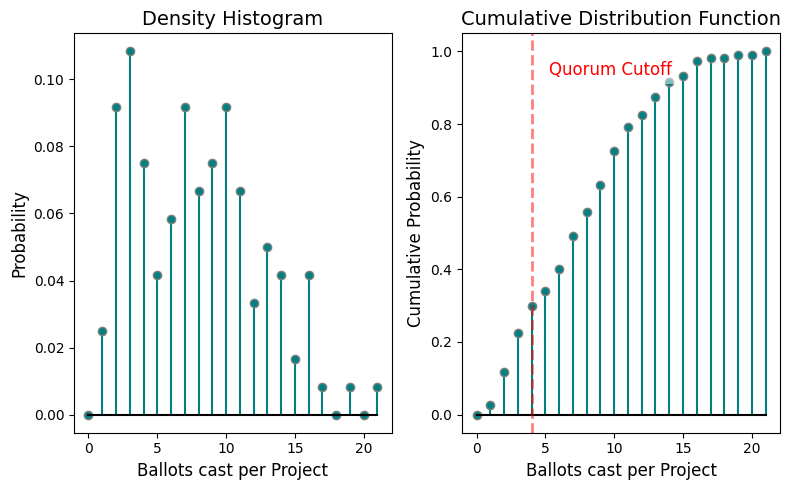

In [15]:
rpgf3lib.votes_distribution_stem(dff, quorum_cutoff=QUORUM, save_fp='../figures/votes_distribution.png')

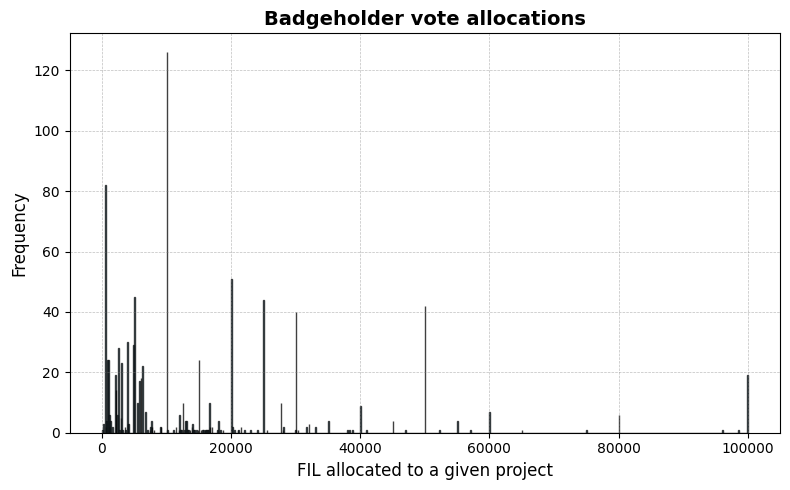

In [16]:
rpgf3lib.votes_per_project_histogram(dff, save_fp='../figures/votes_per_project.png')

In [17]:
dff['amount'].value_counts()

amount
10000    126
500       82
20000     51
5000      45
25000     44
        ... 
23000      1
65000      1
47000      1
0          1
2740       1
Name: count, Length: 135, dtype: int64

In [18]:
allocations, eliminated, reasons, stats, failed_df, success_df = rpgf3lib.run_allocation_analysis(
    dff,
    quorum_cutoff=QUORUM,
    min_funding=MIN_FUNDING,
    total_funding=TOTAL_FUNDING,
    project_names=projectid2name,
    scoring_fn='sum',
    verbose=False
)

Round 1 total score: 14445789
Round 2 total score: 14422689


In [19]:
print(f'Failed {len(failed_df)} projects')
print(f'Success {len(success_df)} projects')
print(f'Total {len(dff.groupby("projectId").size())} projects')

Failed 29 projects
Success 91 projects
Total 120 projects


In [20]:
# Combine failed_df and success_df, then sort by allocation
# Prepare failed_df: add Allocation column (0 for failed projects) and Quorum reached column
failed_df_combined = failed_df.copy()
failed_df_combined['Allocation (FIL)'] = 0.0
failed_df_combined['Quorum reached'] = failed_df_combined['Vote Count'] >= QUORUM

# Prepare success_df: add Quorum reached column (all should be True since they succeeded)
success_df_combined = success_df.copy()
success_df_combined['Quorum reached'] = success_df_combined['Vote Count'] >= QUORUM
# Rename 'Final Allocation (FIL)' to 'Allocation (FIL)' for consistency
success_df_combined = success_df_combined.rename(columns={'Final Allocation (FIL)': 'Allocation (FIL)'})

# Select the columns we want from each dataframe
failed_selected = failed_df_combined[['Project Name', 'Vote Count', 'Quorum reached', 'Allocation (FIL)']]
success_selected = success_df_combined[['Project Name', 'Vote Count', 'Quorum reached', 'Allocation (FIL)']]

# Combine the dataframes
combined_df = pd.concat([failed_selected, success_selected], ignore_index=True)

# Sort by Allocation (FIL) in descending order
combined_df = combined_df.sort_values('Allocation (FIL)', ascending=False).reset_index(drop=True)

# Display the combined dataframe
print(f"Total projects: {len(combined_df)}")
print(f"Projects that reached quorum: {combined_df['Quorum reached'].sum()}")
print(f"Projects that didn't reach quorum: {(~combined_df['Quorum reached']).sum()}")
print(f"\nCombined dataframe (sorted by Allocation):")
display(combined_df)
combined_df.to_csv('../data/all_results.csv', index=False)


Total projects: 120
Projects that reached quorum: 93
Projects that didn't reach quorum: 27

Combined dataframe (sorted by Allocation):


,Project Name,Vote Count,Quorum reached,Allocation (FIL)
0,Filecoin Onchain Cloud (FOC) - Verifiable Stor...,14,True,20461.54
1,FilOz - Advancing the Filecoin Protocol,17,True,18142.61
2,FIL-B (FIL Builders) DX and Community,15,True,16049.88
3,go-libp2p,21,True,15659.49
4,Filecoin Data Portal,15,True,15432.30
...,...,...,...,...
115,MYRAD,3,False,0.00
116,OpenEdStore Decentralized Educational Storage ...,1,False,0.00
117,Root Key Holder management portal,2,False,0.00
118,Retrieval Tester,4,True,0.00


In [21]:
failed_df.to_csv('../data/failed_projects.csv', index=False)
success_df.to_csv('../data/successful_projects.csv', index=False)

In [22]:
failed_df

,Project Name,Vote Count,Score,Round,Reason,category
0,Guide To Filecoin - Easing the Transition to F...,2,8044,1,Failed quorum with 2 votes,Edu & Outreach
1,Curio APT Repository (Filecoin APT),3,24287,1,Failed quorum with 3 votes,Infra & Deps
2,Filmint,3,28544,1,Failed quorum with 3 votes,Product & UX
3,JZFS - Building Data Hub-and-Spoke Model with ...,2,13969,1,Failed quorum with 2 votes,Infra & Deps
4,FilDOS,3,12496,1,Failed quorum with 3 votes,Product & UX
5,Root Key Holder management portal,2,7455,1,Failed quorum with 2 votes,Governance
6,Retrieval Tester,4,11205,1,Failed minimum funding with 395.59,Tooling & Utilities
7,IPFS及Filecoin价值资讯传递（南山居士Hill）,2,6895,1,Failed quorum with 2 votes,Edu & Outreach
8,NanoDC Project,3,10705,1,Failed quorum with 3 votes,Product & UX
9,boxo-starter-kit,4,11895,1,Failed minimum funding with 419.95,Edu & Outreach


In [23]:
list(success_df['Project Name'].unique())

['Filecoin Onchain Cloud (FOC) - Verifiable Storage, Retrieval, and Payments',
 'FilOz - Advancing the Filecoin Protocol',
 'FIL-B (FIL Builders) DX and Community',
 'go-libp2p',
 'Filecoin Data Portal',
 'Curio Storage',
 'drand - the distributed randomness beacon project powering the League of Entropy and Filecoin Leader Election',
 'UCAN',
 'Secured Finance',
 'FilPonto: Public goods chain infrastructure & collaborations support for Filecoin',
 'Lotus, Builtin Actors, and ref-FVM - Core Filecoin Protocol Implementations',
 'Filscan Explorer',
 'Crossfi',
 'ND Labs',
 'Filliquid',
 'Eastore',
 'Lily: blockchain data extraction for Filecoin',
 'Beryx Filecoin Explorer',
 'Blockscout Open Source Filecoin Explorer',
 'Beryx Filecoin API',
 'Chain.Love',
 'Lighthouse',
 'Forest',
 'FIP Editors - Filecoin Improvement Proposal Governance',
 'filecoin-checker',
 'Asia-SPWG',
 'Filecoin Beam',
 'Boost',
 'Drips',
 'Old Faithful',
 'chainfee',
 'OrbitChina',
 'FIP 100 Research & Development',

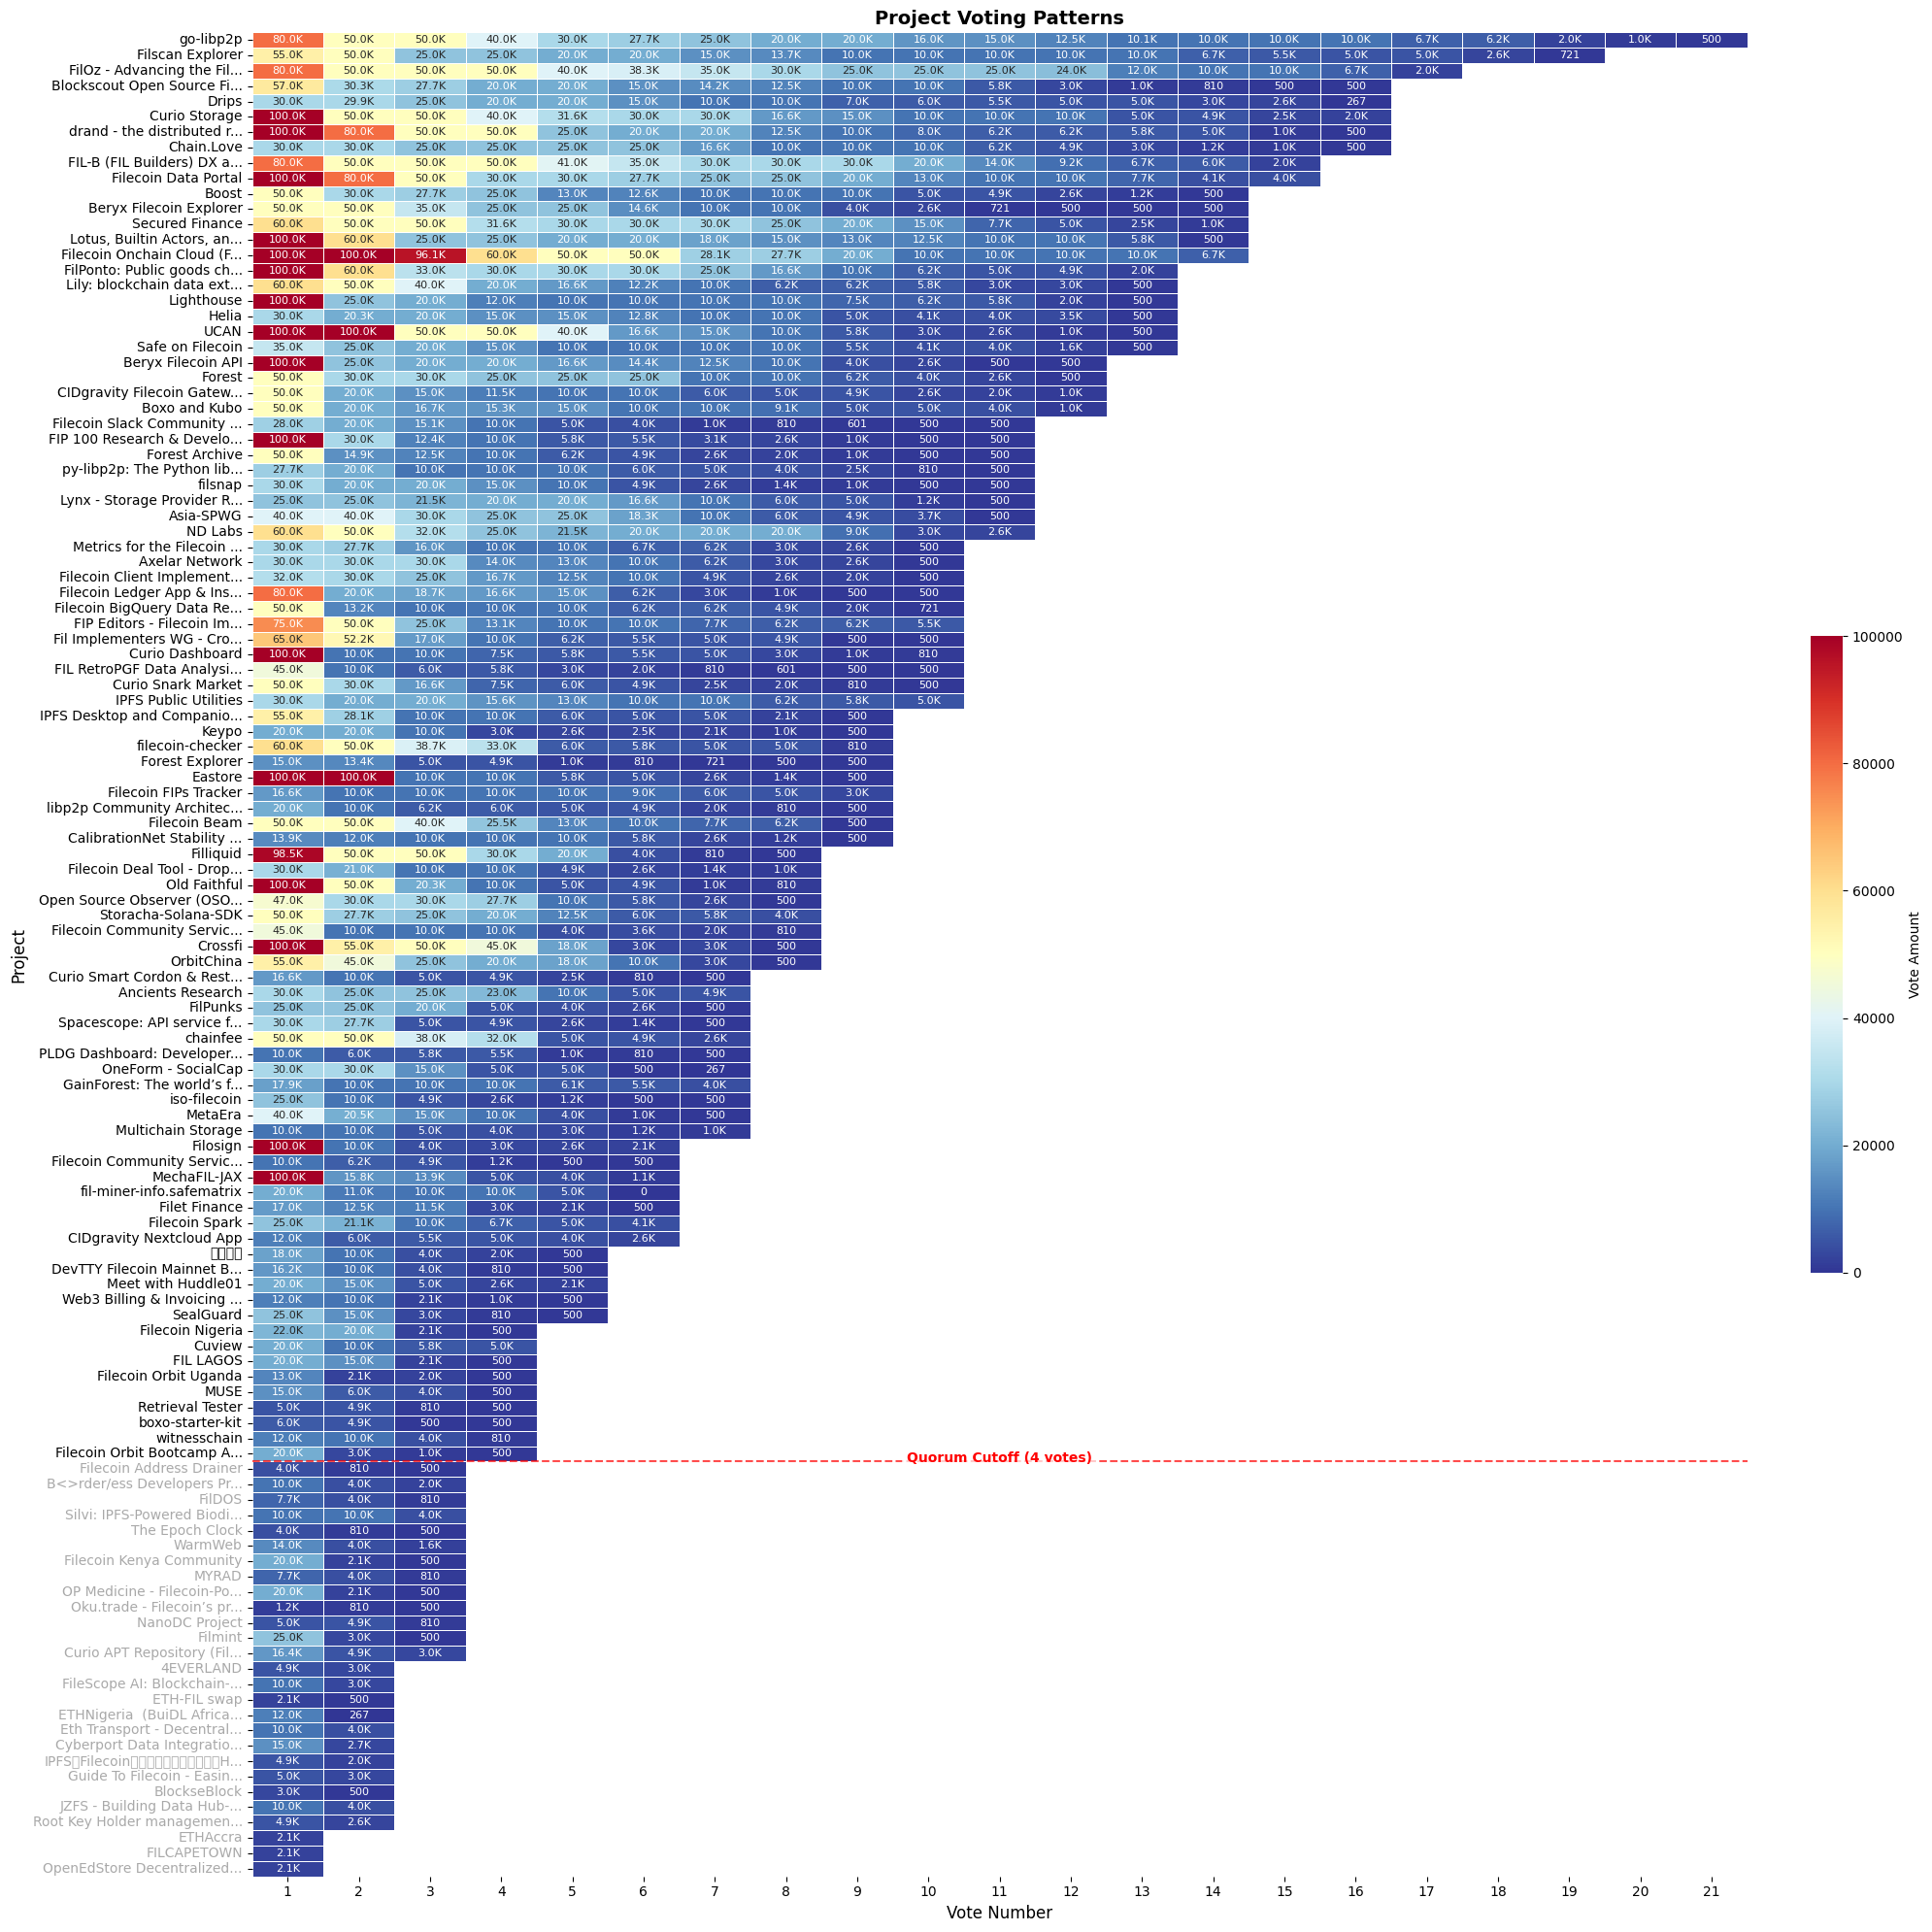

In [24]:
rpgf3lib.project_patterns_withname(
    dff, 
    figsize=(20, 20), 
    save_fp='../figures/project_patterns.png',
    quorum_threshold=QUORUM
)

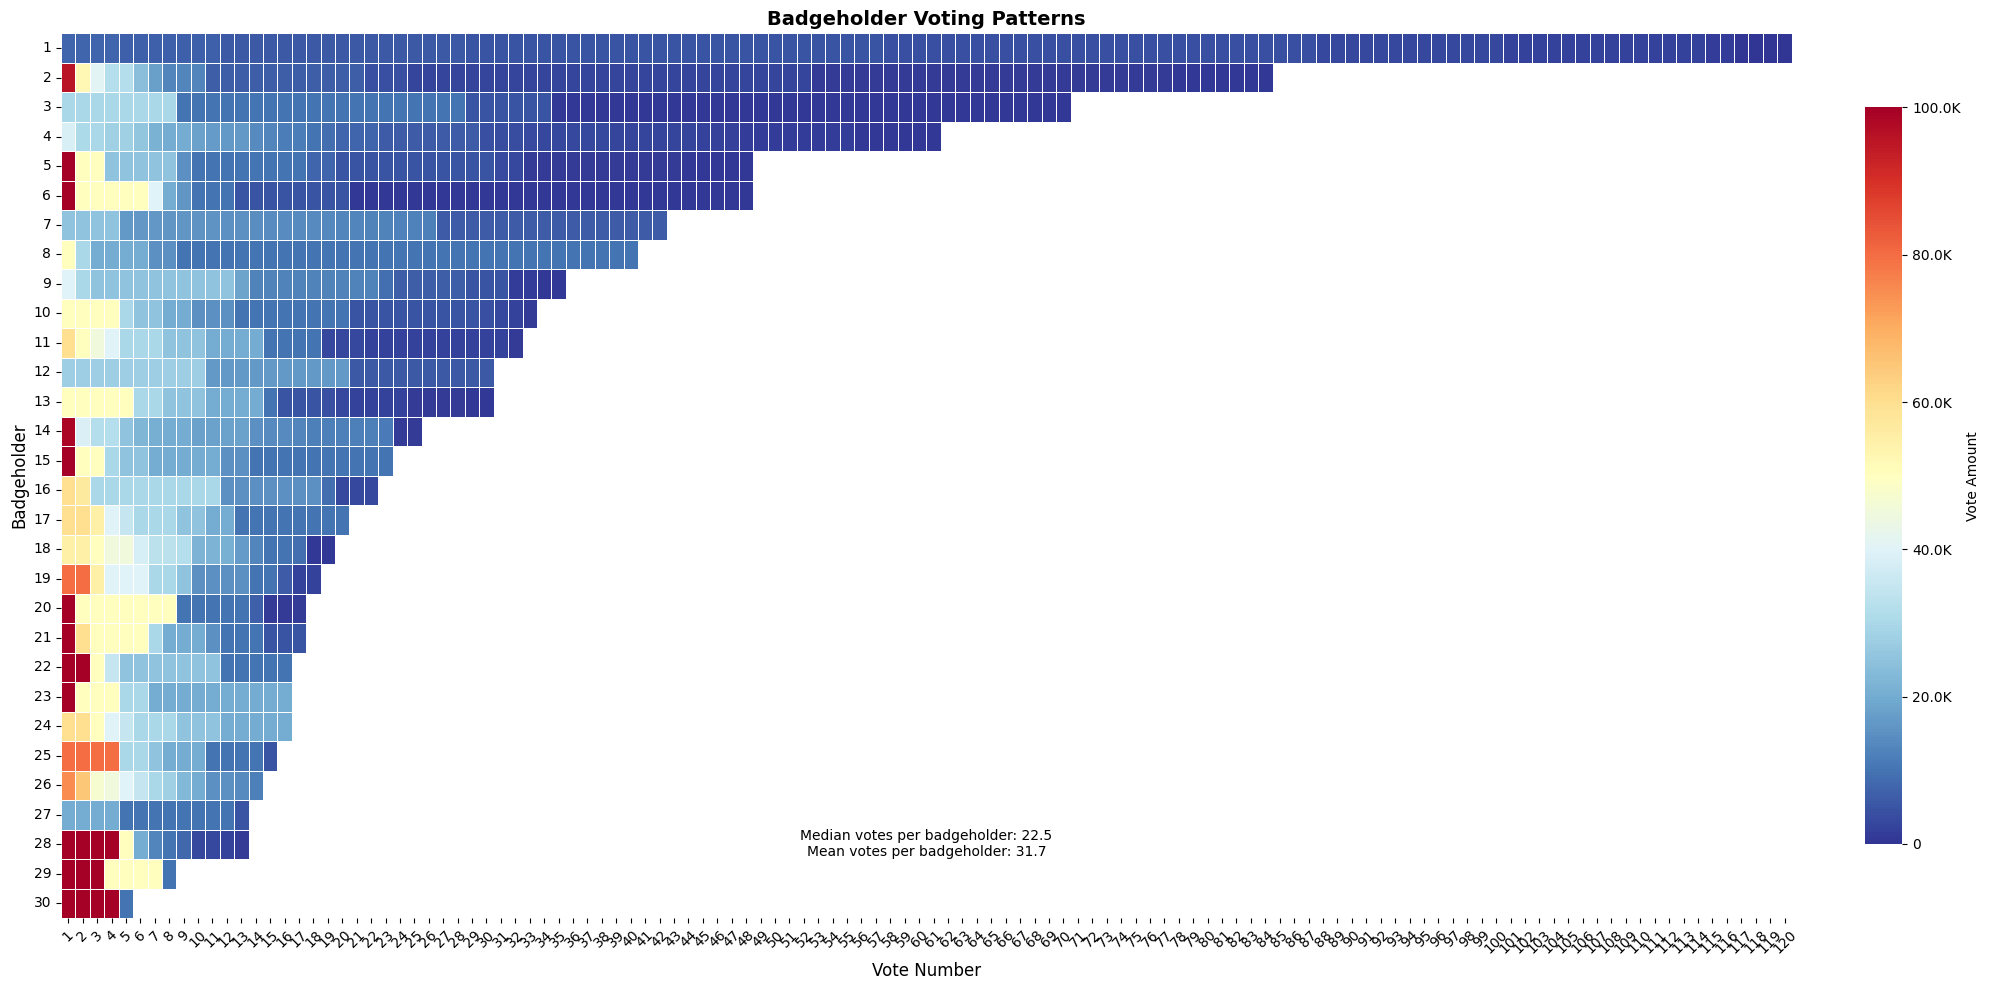

In [25]:
rpgf3lib.badgeholder_patterns2(dff, figsize=(20, 10), save_fp='../figures/badgeholder_patterns.png')

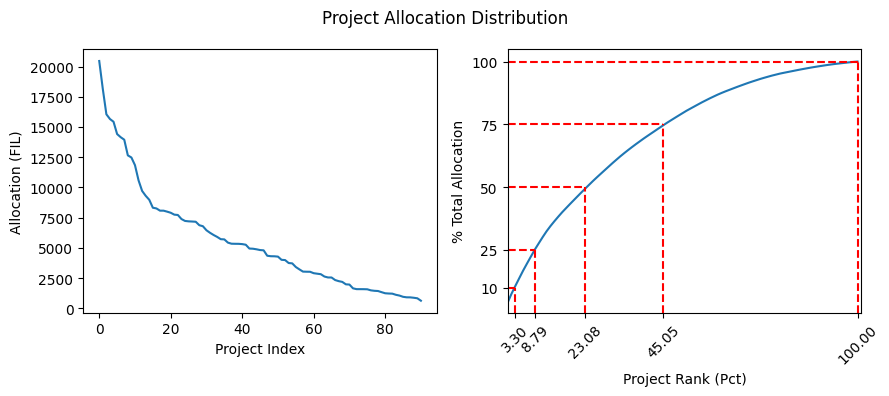

In [26]:
rpgf3lib.project_distribution_patterns(allocations, figsize=(9,4), save_fp='../figures/project_distribution.png')

In [45]:
upload_to_plotly = False

plotly_fig = rpgf3lib.plot_allocations_sunburst(success_df, 
                                                show_project_labels=True,
                                                save_fp='../figures/rpgf3_project_allocations.png')
plotly_fig.show()
if upload_to_plotly:
    with open(os.path.join(os.environ['HOME'], 'code', 'cel', 'auth', 'plotly.json'), 'r') as fp:
        plotly_auth = json.load(fp)
    chart_studio.tools.set_credentials_file(username=plotly_auth['username'], api_key=plotly_auth['api_key'])
    py.plot(plotly_fig, filename='rpgf2_project_allocations', auto_open=True)

Input DataFrame shape: (91, 7)
DataFrame columns: ['Project Name', 'Vote Count', 'Average Score', 'Std Dev', 'Final Allocation (FIL)', 'category', 'PctOfTotal']
Sample of input data:
                                         Project Name  Vote Count  \
81  Filecoin Onchain Cloud (FOC) - Verifiable Stor...          14   
42            FilOz - Advancing the Filecoin Protocol          17   
28              FIL-B (FIL Builders) DX and Community          15   
22                                          go-libp2p          21   
64                               Filecoin Data Portal          15   

    Average Score  Std Dev  Final Allocation (FIL)             category  \
81       41332.00 35426.63                20461.54  Tooling & Utilities   
42       30180.53 20082.92                18142.61         Protocol R&D   
28       30259.13 21604.06                16049.88       Edu & Outreach   
22       21087.95 19854.64                15659.49         Infra & Deps   
64       29094.80 27877.38 

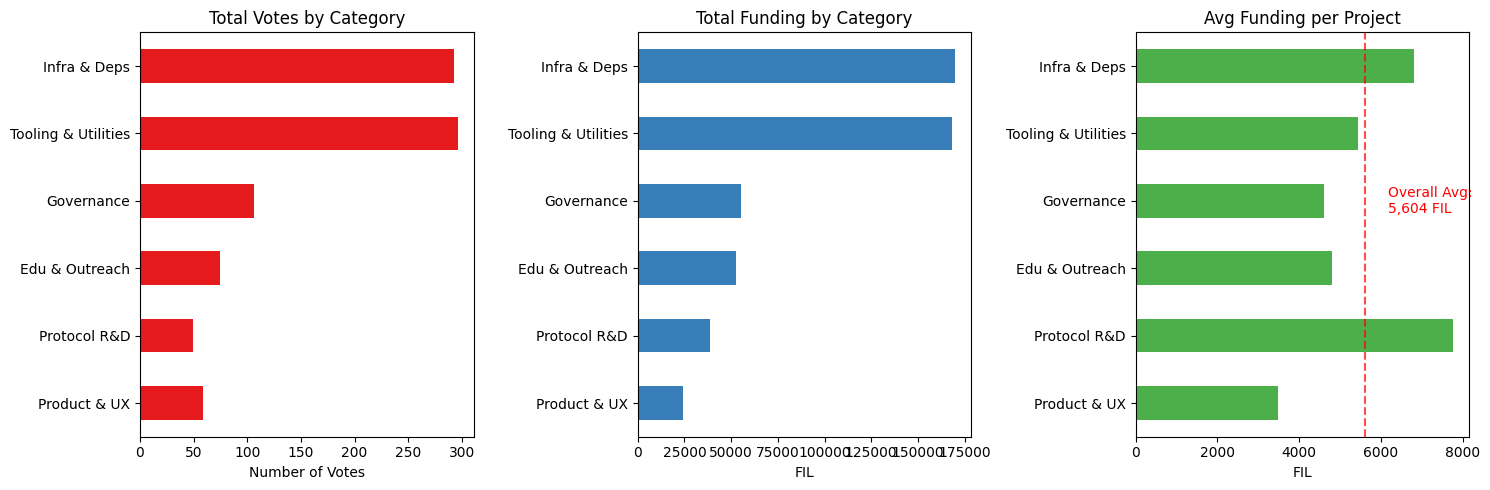

In [28]:
f = rpgf3lib.plot_category_metrics(
    success_df, 
    style='bar',
    save_fp='../figures/category_metrics.png'
)

Round 1 total score: 14765911
Round 2 total score: 14598028
Round 1 total score: 14759557
Round 2 total score: 14598028
Round 1 total score: 14652146
Round 2 total score: 14580288
Round 1 total score: 14445789
Round 2 total score: 14422689
Round 1 total score: 14205222
Round 2 total score: 14205222
Round 1 total score: 14024670
Round 2 total score: 14024670
Round 1 total score: 13530376
Round 2 total score: 13530376
Round 1 total score: 12681929
Round 2 total score: 12681929
Round 1 total score: 11314276
Round 2 total score: 11314276
Round 1 total score: 10245357
Round 2 total score: 10245357


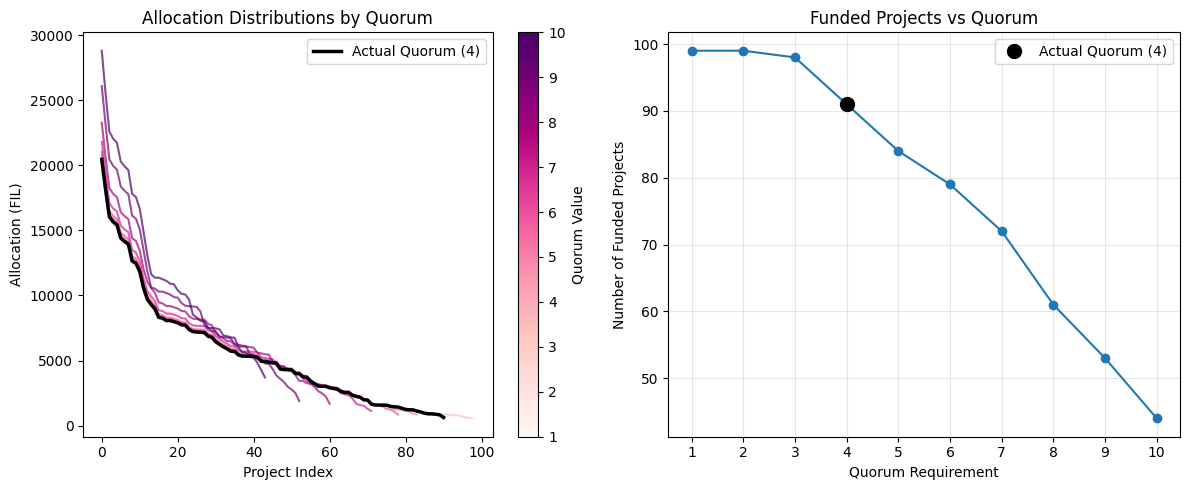

In [29]:
f = rpgf3lib.plot_quorum_sweep(
    dff, 
    actual_quorum=QUORUM,
    min_funding=MIN_FUNDING,
    total_funding=TOTAL_FUNDING,
    save_fp='../figures/quorum_sweep.png'
)


Round 1 total score: 14445789
Round 2 total score: 14422689
Round 1 total score: 12668046
Round 2 total score: 12668046
Round 1 total score: 13015789
Round 2 total score: 12992689
Round 1 total score: 11225986
Round 2 total score: 11225986


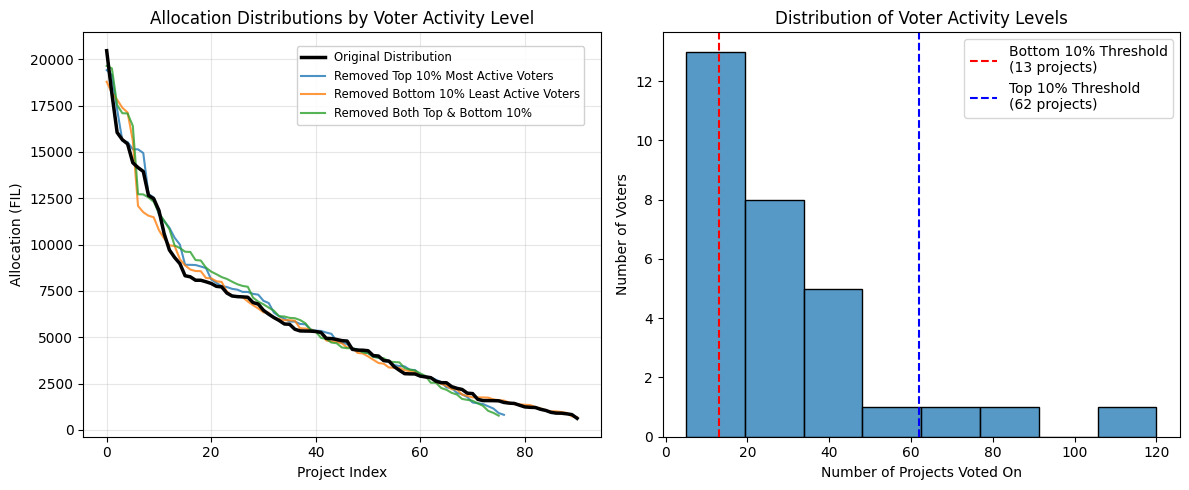

In [30]:
f = rpgf3lib.plot_temperature_analysis(
    dff, 
    quorum_cutoff=QUORUM,
    min_funding=MIN_FUNDING,
    total_funding=TOTAL_FUNDING,
    save_fp='../figures/temperature_analysis.png'
)


Round 1 total score: 14445789
Round 2 total score: 14422689
Round 1 total score: 1365008.0537771652
Round 2 total score: 1365008.0537771652
Round 1 total score: 966679.0
Round 2 total score: 966679.0


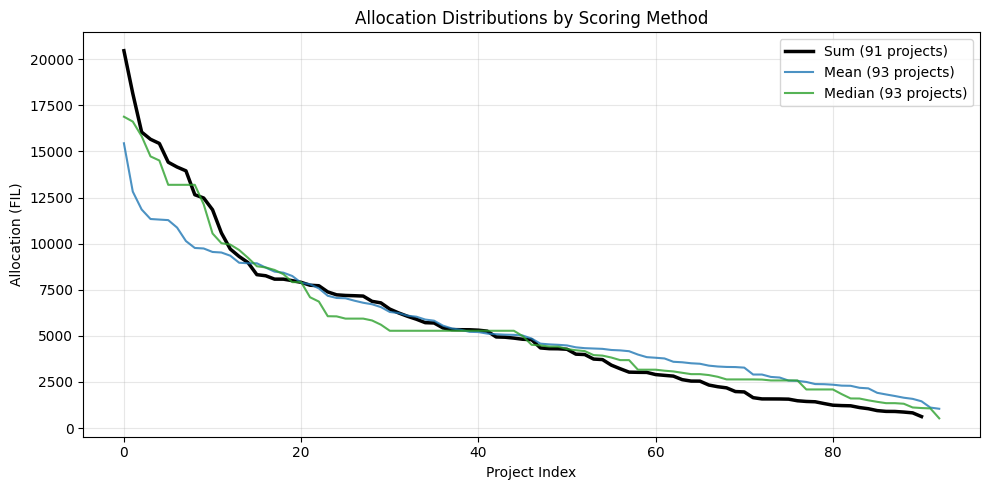

In [31]:
f = rpgf3lib.plot_scoring_comparison(
    dff, 
    quorum_cutoff=QUORUM,
    min_funding=MIN_FUNDING,
    total_funding=TOTAL_FUNDING,
    save_fp='../figures/scoring_comparison.png'
)

In [32]:
bootstrap_allocations = rpgf3lib.bootstrap_allocation_distribution(
    dff, 
    n_samples=1000,
    min_voters=28, 
    quorum_cutoff=QUORUM, 
    min_funding=MIN_FUNDING, 
    total_funding=TOTAL_FUNDING, 
    sample_size=None  # choose between min_voters and total voters randomly
)

  0%|          | 3/1000 [00:00<00:37, 26.47it/s]

Round 1 total score: 13837488
Round 2 total score: 13831093
Round 1 total score: 13908664
Round 2 total score: 13880682
Round 1 total score: 13729678
Round 2 total score: 13704314
Round 1 total score: 14163693
Round 2 total score: 14137954
Round 1 total score: 14721996
Round 2 total score: 14631232
Round 1 total score: 14312599
Round 2 total score: 14306981


  1%|          | 12/1000 [00:00<00:36, 27.31it/s]

Round 1 total score: 14270396
Round 2 total score: 14250844
Round 1 total score: 14192060
Round 2 total score: 14120790
Round 1 total score: 14349283
Round 2 total score: 14310969
Round 1 total score: 13610839
Round 2 total score: 13588647
Round 1 total score: 14441067
Round 2 total score: 14414775
Round 1 total score: 13080224
Round 2 total score: 13059224


  2%|▏         | 15/1000 [00:00<00:35, 27.61it/s]

Round 1 total score: 13608177
Round 2 total score: 13608177
Round 1 total score: 12866846
Round 2 total score: 12866846
Round 1 total score: 14316449
Round 2 total score: 14298436
Round 1 total score: 14466120
Round 2 total score: 14466120
Round 1 total score: 13809320
Round 2 total score: 13769462
Round 1 total score: 13812230
Round 2 total score: 13791750


  2%|▏         | 22/1000 [00:00<00:34, 28.00it/s]

Round 1 total score: 14039494
Round 2 total score: 13997918
Round 1 total score: 14403442
Round 2 total score: 14356112
Round 1 total score: 13980200
Round 2 total score: 13919967
Round 1 total score: 13919879
Round 2 total score: 13885858
Round 1 total score: 14537908
Round 2 total score: 14526939
Round 1 total score: 13130015
Round 2 total score: 13110795


  3%|▎         | 28/1000 [00:01<00:34, 28.13it/s]

Round 1 total score: 13159204
Round 2 total score: 13147309
Round 1 total score: 13107393
Round 2 total score: 13089159
Round 1 total score: 14511723
Round 2 total score: 14429548
Round 1 total score: 13674593
Round 2 total score: 13629703
Round 1 total score: 13939118
Round 2 total score: 13915638
Round 1 total score: 13527751
Round 2 total score: 13512650


  4%|▎         | 35/1000 [00:01<00:33, 28.86it/s]

Round 1 total score: 13648567
Round 2 total score: 13630888
Round 1 total score: 13503521
Round 2 total score: 13490521
Round 1 total score: 12218327
Round 2 total score: 12206432
Round 1 total score: 14493757
Round 2 total score: 14410737
Round 1 total score: 14809698
Round 2 total score: 14739762
Round 1 total score: 13178732
Round 2 total score: 13132766


  4%|▍         | 41/1000 [00:01<00:33, 28.56it/s]

Round 1 total score: 13157402
Round 2 total score: 13157402
Round 1 total score: 13849028
Round 2 total score: 13826489
Round 1 total score: 13933426
Round 2 total score: 13933426
Round 1 total score: 13399275
Round 2 total score: 13399275
Round 1 total score: 14381332
Round 2 total score: 14320699
Round 1 total score: 12642305
Round 2 total score: 12642305


  5%|▍         | 47/1000 [00:01<00:33, 28.21it/s]

Round 1 total score: 14638488
Round 2 total score: 14600260
Round 1 total score: 13299047
Round 2 total score: 13282237
Round 1 total score: 14117974
Round 2 total score: 14117974
Round 1 total score: 14301908
Round 2 total score: 14181952
Round 1 total score: 14654782
Round 2 total score: 14645844
Round 1 total score: 13910960
Round 2 total score: 13885924


  5%|▌         | 53/1000 [00:01<00:34, 27.44it/s]

Round 1 total score: 13423108
Round 2 total score: 13382108
Round 1 total score: 14882045
Round 2 total score: 14837209
Round 1 total score: 14611345
Round 2 total score: 14551834
Round 1 total score: 14357772
Round 2 total score: 14354272
Round 1 total score: 14077000
Round 2 total score: 14038500
Round 1 total score: 13482691
Round 2 total score: 13392910


  6%|▌         | 59/1000 [00:02<00:34, 26.99it/s]

Round 1 total score: 14618625
Round 2 total score: 14549875
Round 1 total score: 13449228
Round 2 total score: 13392522
Round 1 total score: 15059010
Round 2 total score: 15029702
Round 1 total score: 13405042
Round 2 total score: 13378036
Round 1 total score: 14039908
Round 2 total score: 13935600
Round 1 total score: 13108388
Round 2 total score: 13099140


  7%|▋         | 66/1000 [00:02<00:32, 28.39it/s]

Round 1 total score: 13736840
Round 2 total score: 13660397
Round 1 total score: 13870542
Round 2 total score: 13768665
Round 1 total score: 13102059
Round 2 total score: 13082059
Round 1 total score: 14295786
Round 2 total score: 14295786
Round 1 total score: 13762972
Round 2 total score: 13753918
Round 1 total score: 14992024
Round 2 total score: 14944408
Round 1 total score: 13178858


  7%|▋         | 73/1000 [00:02<00:31, 29.08it/s]

Round 2 total score: 13178858
Round 1 total score: 13809001
Round 2 total score: 13809001
Round 1 total score: 14284902
Round 2 total score: 14255375
Round 1 total score: 14009560
Round 2 total score: 13882658
Round 1 total score: 13644515
Round 2 total score: 13631938
Round 1 total score: 13777236
Round 2 total score: 13777236
Round 1 total score: 14749582
Round 2 total score: 14732402


  8%|▊         | 79/1000 [00:02<00:32, 28.36it/s]

Round 1 total score: 13616374
Round 2 total score: 13604229
Round 1 total score: 13735160
Round 2 total score: 13724160
Round 1 total score: 14553074
Round 2 total score: 14494915
Round 1 total score: 13975552
Round 2 total score: 13936146
Round 1 total score: 15202134
Round 2 total score: 15121707
Round 1 total score: 13155148
Round 2 total score: 13143148


  8%|▊         | 82/1000 [00:02<00:33, 27.64it/s]

Round 1 total score: 13082392
Round 2 total score: 13082392
Round 1 total score: 14190819
Round 2 total score: 14104779
Round 1 total score: 14137918
Round 2 total score: 14129330
Round 1 total score: 13902306
Round 2 total score: 13822248
Round 1 total score: 14267908
Round 2 total score: 14157546
Round 1 total score: 14284002
Round 2 total score: 14274322


  9%|▉         | 88/1000 [00:03<00:34, 26.65it/s]

Round 1 total score: 13852188
Round 2 total score: 13852188
Round 1 total score: 13207910
Round 2 total score: 13142558
Round 1 total score: 13635121
Round 2 total score: 13569043
Round 1 total score: 14891912
Round 2 total score: 14793885
Round 1 total score: 14813241
Round 2 total score: 14813241
Round 1 total score: 14818286
Round 2 total score: 14798666


  9%|▉         | 94/1000 [00:03<00:33, 26.80it/s]

Round 1 total score: 13962012
Round 2 total score: 13899410
Round 1 total score: 13785088
Round 2 total score: 13777588
Round 1 total score: 13954087
Round 2 total score: 13939587
Round 1 total score: 14201004
Round 2 total score: 14182194
Round 1 total score: 14790388
Round 2 total score: 14733432
Round 1 total score: 14665996
Round 2 total score: 14587106


 10%|█         | 100/1000 [00:03<00:34, 26.13it/s]

Round 1 total score: 14799796
Round 2 total score: 14799796
Round 1 total score: 13573383
Round 2 total score: 13560988
Round 1 total score: 14433470
Round 2 total score: 14433470
Round 1 total score: 14513234
Round 2 total score: 14513234
Round 1 total score: 13521982
Round 2 total score: 13504742
Round 1 total score: 13835838
Round 2 total score: 13795923


 11%|█         | 106/1000 [00:03<00:34, 25.57it/s]

Round 1 total score: 13126545
Round 2 total score: 13120766
Round 1 total score: 13468128
Round 2 total score: 13405892
Round 1 total score: 14447743
Round 2 total score: 14415756
Round 1 total score: 13079112
Round 2 total score: 13079112
Round 1 total score: 13635169
Round 2 total score: 13635169
Round 1 total score: 13543691
Round 2 total score: 13536796


 11%|█▏        | 113/1000 [00:04<00:32, 27.31it/s]

Round 1 total score: 13313006
Round 2 total score: 13265352
Round 1 total score: 13820794
Round 2 total score: 13794794
Round 1 total score: 15030292
Round 2 total score: 14996862
Round 1 total score: 13639254
Round 2 total score: 13619216
Round 1 total score: 14162812
Round 2 total score: 14151044
Round 1 total score: 14228954
Round 2 total score: 14215954


 12%|█▏        | 119/1000 [00:04<00:33, 26.65it/s]

Round 1 total score: 14114771
Round 2 total score: 14042876
Round 1 total score: 14732516
Round 2 total score: 14688140
Round 1 total score: 12309307
Round 2 total score: 12309307
Round 1 total score: 13479115
Round 2 total score: 13479115
Round 1 total score: 14356763
Round 2 total score: 14331100
Round 1 total score: 14427248
Round 2 total score: 14390801


 12%|█▎        | 125/1000 [00:04<00:33, 26.07it/s]

Round 1 total score: 13863772
Round 2 total score: 13852609
Round 1 total score: 14686950
Round 2 total score: 14653762
Round 1 total score: 14557633
Round 2 total score: 14557633
Round 1 total score: 14556250
Round 2 total score: 14495570
Round 1 total score: 13550355
Round 2 total score: 13538181
Round 1 total score: 14365592
Round 2 total score: 14314884


 13%|█▎        | 131/1000 [00:04<00:32, 26.99it/s]

Round 1 total score: 13780433
Round 2 total score: 13780433
Round 1 total score: 13962005
Round 2 total score: 13945479
Round 1 total score: 13409453
Round 2 total score: 13336796
Round 1 total score: 12917184
Round 2 total score: 12862151
Round 1 total score: 13179176
Round 2 total score: 13166781
Round 1 total score: 14655624
Round 2 total score: 14563092


 14%|█▎        | 137/1000 [00:04<00:31, 27.46it/s]

Round 1 total score: 13879331
Round 2 total score: 13874548
Round 1 total score: 13205198
Round 2 total score: 13205198
Round 1 total score: 14873998
Round 2 total score: 14809762
Round 1 total score: 14493040
Round 2 total score: 14461560
Round 1 total score: 12699897
Round 2 total score: 12699897
Round 1 total score: 14771068
Round 2 total score: 14757568


 14%|█▍        | 144/1000 [00:05<00:30, 27.98it/s]

Round 1 total score: 14410223
Round 2 total score: 14399328
Round 1 total score: 13070000
Round 2 total score: 13063000
Round 1 total score: 14608938
Round 2 total score: 14570585
Round 1 total score: 14211136
Round 2 total score: 14105424
Round 1 total score: 14333697
Round 2 total score: 14307534
Round 1 total score: 14464513
Round 2 total score: 14441723


 15%|█▌        | 150/1000 [00:05<00:30, 27.61it/s]

Round 1 total score: 13823720
Round 2 total score: 13789850
Round 1 total score: 14006875
Round 2 total score: 13924874
Round 1 total score: 13928444
Round 2 total score: 13928444
Round 1 total score: 14345178
Round 2 total score: 14235186
Round 1 total score: 14143009
Round 2 total score: 14117959
Round 1 total score: 13044816
Round 2 total score: 13021196


 16%|█▌        | 156/1000 [00:05<00:30, 27.41it/s]

Round 1 total score: 13671852
Round 2 total score: 13650506
Round 1 total score: 13800272
Round 2 total score: 13778586
Round 1 total score: 14403509
Round 2 total score: 14377243
Round 1 total score: 14175745
Round 2 total score: 14121391
Round 1 total score: 14254018
Round 2 total score: 14219059
Round 1 total score: 14669182
Round 2 total score: 14636248


 16%|█▌        | 162/1000 [00:05<00:30, 27.56it/s]

Round 1 total score: 13895957
Round 2 total score: 13882099
Round 1 total score: 14734420
Round 2 total score: 14708940
Round 1 total score: 14619211
Round 2 total score: 14518056
Round 1 total score: 13591890
Round 2 total score: 13591890
Round 1 total score: 14145834
Round 2 total score: 14133939
Round 1 total score: 14881362
Round 2 total score: 14820356


 17%|█▋        | 169/1000 [00:06<00:30, 27.55it/s]

Round 1 total score: 14786344
Round 2 total score: 14710479
Round 1 total score: 13908980
Round 2 total score: 13891500
Round 1 total score: 12782028
Round 2 total score: 12754288
Round 1 total score: 13240809
Round 2 total score: 13240809
Round 1 total score: 14328351
Round 2 total score: 14328351
Round 1 total score: 13861818
Round 2 total score: 13806561


 18%|█▊        | 175/1000 [00:06<00:29, 27.99it/s]

Round 1 total score: 13972748
Round 2 total score: 13924869
Round 1 total score: 14144073
Round 2 total score: 14067407
Round 1 total score: 12590976
Round 2 total score: 12558410
Round 1 total score: 14463181
Round 2 total score: 14402836
Round 1 total score: 13050012
Round 2 total score: 13050012
Round 1 total score: 13607676
Round 2 total score: 13596707


 18%|█▊        | 178/1000 [00:06<00:30, 27.30it/s]

Round 1 total score: 14305236
Round 2 total score: 14261671
Round 1 total score: 14618638
Round 2 total score: 14557526
Round 1 total score: 14557287
Round 2 total score: 14490575
Round 1 total score: 13700045
Round 2 total score: 13587231
Round 1 total score: 13885182
Round 2 total score: 13867324
Round 1 total score: 14078555
Round 2 total score: 14046124


 18%|█▊        | 184/1000 [00:06<00:29, 27.41it/s]

Round 1 total score: 13045902
Round 2 total score: 13035615
Round 1 total score: 13578120
Round 2 total score: 13534771
Round 1 total score: 13294163
Round 2 total score: 13281768
Round 1 total score: 14584587
Round 2 total score: 14537505
Round 1 total score: 14248947
Round 2 total score: 14205727
Round 1 total score: 13707315
Round 2 total score: 13686049


 19%|█▉        | 190/1000 [00:06<00:30, 26.85it/s]

Round 1 total score: 13545649
Round 2 total score: 13491841
Round 1 total score: 13865434
Round 2 total score: 13853039
Round 1 total score: 13758788
Round 2 total score: 13750978
Round 1 total score: 14245519
Round 2 total score: 14233624
Round 1 total score: 14858934
Round 2 total score: 14820427
Round 1 total score: 14851636
Round 2 total score: 14737362


 20%|█▉        | 199/1000 [00:07<00:28, 28.02it/s]

Round 1 total score: 14510529
Round 2 total score: 14510529
Round 1 total score: 14331955
Round 2 total score: 14320097
Round 1 total score: 14131364
Round 2 total score: 14073204
Round 1 total score: 13727953
Round 2 total score: 13716014
Round 1 total score: 13094797
Round 2 total score: 13053081
Round 1 total score: 14617207
Round 2 total score: 14525502


 20%|██        | 202/1000 [00:07<00:28, 28.25it/s]

Round 1 total score: 14764222
Round 2 total score: 14762222
Round 1 total score: 14133880
Round 2 total score: 14025120
Round 1 total score: 13835978
Round 2 total score: 13819625
Round 1 total score: 13808490
Round 2 total score: 13769974
Round 1 total score: 13408014
Round 2 total score: 13408014
Round 1 total score: 14246330
Round 2 total score: 14204092


 21%|██        | 208/1000 [00:07<00:28, 27.68it/s]

Round 1 total score: 14221245
Round 2 total score: 14221245
Round 1 total score: 14477149
Round 2 total score: 14468899
Round 1 total score: 13472719
Round 2 total score: 13380953
Round 1 total score: 13283693
Round 2 total score: 13271798
Round 1 total score: 14394358
Round 2 total score: 14351970
Round 1 total score: 13856940
Round 2 total score: 13843694


 22%|██▏       | 215/1000 [00:07<00:27, 28.04it/s]

Round 1 total score: 13961048
Round 2 total score: 13940424
Round 1 total score: 13792990
Round 2 total score: 13765329
Round 1 total score: 13319195
Round 2 total score: 13319195
Round 1 total score: 14320211
Round 2 total score: 14320211
Round 1 total score: 13299440
Round 2 total score: 13299440
Round 1 total score: 14012828
Round 2 total score: 13939054


 22%|██▏       | 221/1000 [00:08<00:27, 28.68it/s]

Round 1 total score: 13738912
Round 2 total score: 13654482
Round 1 total score: 14346973
Round 2 total score: 14261812
Round 1 total score: 14017991
Round 2 total score: 14017991
Round 1 total score: 13023328
Round 2 total score: 13023328
Round 1 total score: 13803582
Round 2 total score: 13733449
Round 1 total score: 13586860
Round 2 total score: 13537520


 23%|██▎       | 227/1000 [00:08<00:28, 27.12it/s]

Round 1 total score: 14058071
Round 2 total score: 14052953
Round 1 total score: 13507627
Round 2 total score: 13453465
Round 1 total score: 13791514
Round 2 total score: 13723928
Round 1 total score: 14140672
Round 2 total score: 14127871
Round 1 total score: 14563879
Round 2 total score: 14522736
Round 1 total score: 14790332
Round 2 total score: 14716326


 23%|██▎       | 234/1000 [00:08<00:26, 28.40it/s]

Round 1 total score: 13517611
Round 2 total score: 13503371
Round 1 total score: 14013250
Round 2 total score: 14001355
Round 1 total score: 12470506
Round 2 total score: 12455100
Round 1 total score: 14806921
Round 2 total score: 14806921
Round 1 total score: 14462335
Round 2 total score: 14430951
Round 1 total score: 13741324
Round 2 total score: 13734588


 24%|██▍       | 240/1000 [00:08<00:26, 28.33it/s]

Round 1 total score: 14359961
Round 2 total score: 14342904
Round 1 total score: 13623131
Round 2 total score: 13601020
Round 1 total score: 14306969
Round 2 total score: 14237173
Round 1 total score: 14233424
Round 2 total score: 14204745
Round 1 total score: 13024374
Round 2 total score: 13024374
Round 1 total score: 14558269
Round 2 total score: 14544737


 25%|██▍       | 246/1000 [00:08<00:28, 26.34it/s]

Round 1 total score: 14115254
Round 2 total score: 14026762
Round 1 total score: 14052442
Round 2 total score: 14052442
Round 1 total score: 14635300
Round 2 total score: 14614304
Round 1 total score: 14614123
Round 2 total score: 14528279
Round 1 total score: 14004690
Round 2 total score: 14004690


 25%|██▍       | 249/1000 [00:09<00:29, 25.20it/s]

Round 1 total score: 14262657
Round 2 total score: 14214457
Round 1 total score: 13758118
Round 2 total score: 13681584
Round 1 total score: 14436432
Round 2 total score: 14390512
Round 1 total score: 14313378
Round 2 total score: 14286440
Round 1 total score: 13161591
Round 2 total score: 13161591
Round 1 total score: 14110198
Round 2 total score: 14023102


 26%|██▌       | 255/1000 [00:09<00:29, 25.60it/s]

Round 1 total score: 13628823
Round 2 total score: 13588717
Round 1 total score: 13602162
Round 2 total score: 13579970
Round 1 total score: 14007750
Round 2 total score: 13985558
Round 1 total score: 14289786
Round 2 total score: 14248136
Round 1 total score: 14432305
Round 2 total score: 14398649
Round 1 total score: 13914476
Round 2 total score: 13883547


 26%|██▋       | 264/1000 [00:09<00:26, 27.29it/s]

Round 1 total score: 14272650
Round 2 total score: 14248166
Round 1 total score: 13847626
Round 2 total score: 13813416
Round 1 total score: 14512922
Round 2 total score: 14474242
Round 1 total score: 13229265
Round 2 total score: 13182355
Round 1 total score: 14413938
Round 2 total score: 14390776
Round 1 total score: 14100410
Round 2 total score: 14067932


 27%|██▋       | 270/1000 [00:09<00:25, 28.08it/s]

Round 1 total score: 14766872
Round 2 total score: 14728222
Round 1 total score: 14292496
Round 2 total score: 14292496
Round 1 total score: 13804576
Round 2 total score: 13804576
Round 1 total score: 13222697
Round 2 total score: 13201154
Round 1 total score: 13245926
Round 2 total score: 13219306
Round 1 total score: 13890164
Round 2 total score: 13878976


 28%|██▊       | 276/1000 [00:10<00:25, 27.99it/s]

Round 1 total score: 14520641
Round 2 total score: 14520641
Round 1 total score: 13194994
Round 2 total score: 13194994
Round 1 total score: 13420392
Round 2 total score: 13400156
Round 1 total score: 14010738
Round 2 total score: 14001593
Round 1 total score: 13164650
Round 2 total score: 13164650
Round 1 total score: 13886552
Round 2 total score: 13886552


 28%|██▊       | 282/1000 [00:10<00:25, 28.24it/s]

Round 1 total score: 13483076
Round 2 total score: 13463752
Round 1 total score: 13626562
Round 2 total score: 13555350
Round 1 total score: 13839106
Round 2 total score: 13839106
Round 1 total score: 13605759
Round 2 total score: 13584803
Round 1 total score: 14238565
Round 2 total score: 14222331
Round 1 total score: 14184872
Round 2 total score: 14150794


 28%|██▊       | 285/1000 [00:10<00:25, 27.69it/s]

Round 1 total score: 14665748
Round 2 total score: 14617429
Round 1 total score: 14699947
Round 2 total score: 14591510
Round 1 total score: 13663710
Round 2 total score: 13644150
Round 1 total score: 13816770
Round 2 total score: 13804122
Round 1 total score: 14066868
Round 2 total score: 14013758
Round 1 total score: 13628105
Round 2 total score: 13628105


 29%|██▉       | 291/1000 [00:10<00:25, 27.54it/s]

Round 1 total score: 13673877
Round 2 total score: 13673877
Round 1 total score: 14404082
Round 2 total score: 14351072
Round 1 total score: 14700920
Round 2 total score: 14690812
Round 1 total score: 14392034
Round 2 total score: 14367440
Round 1 total score: 13697264
Round 2 total score: 13630320
Round 1 total score: 14250513
Round 2 total score: 14215132


 30%|███       | 300/1000 [00:10<00:24, 28.03it/s]

Round 1 total score: 13626034
Round 2 total score: 13614724
Round 1 total score: 13131021
Round 2 total score: 13131021
Round 1 total score: 14309415
Round 2 total score: 14264719
Round 1 total score: 13662594
Round 2 total score: 13662594
Round 1 total score: 14263955
Round 2 total score: 14252060
Round 1 total score: 14141614
Round 2 total score: 14128114


 30%|███       | 303/1000 [00:11<00:25, 27.47it/s]

Round 1 total score: 13176166
Round 2 total score: 13168166
Round 1 total score: 14467043
Round 2 total score: 14385536
Round 1 total score: 13443819
Round 2 total score: 13359889
Round 1 total score: 12615404
Round 2 total score: 12615404
Round 1 total score: 14749292
Round 2 total score: 14729432
Round 1 total score: 12970535
Round 2 total score: 12943377


 31%|███       | 310/1000 [00:11<00:24, 28.59it/s]

Round 1 total score: 14509177
Round 2 total score: 14475885
Round 1 total score: 13856914
Round 2 total score: 13856914
Round 1 total score: 14328760
Round 2 total score: 14292093
Round 1 total score: 13733998
Round 2 total score: 13709676
Round 1 total score: 12912927
Round 2 total score: 12901307
Round 1 total score: 14482205
Round 2 total score: 14425414


 32%|███▏      | 316/1000 [00:11<00:24, 27.76it/s]

Round 1 total score: 14157695
Round 2 total score: 14079044
Round 1 total score: 14780336
Round 2 total score: 14767821
Round 1 total score: 14752158
Round 2 total score: 14739263
Round 1 total score: 14173429
Round 2 total score: 14163102
Round 1 total score: 14322868
Round 2 total score: 14322868
Round 1 total score: 14396163
Round 2 total score: 14373163


 32%|███▏      | 322/1000 [00:11<00:24, 27.84it/s]

Round 1 total score: 14406108
Round 2 total score: 14384692
Round 1 total score: 14836696
Round 2 total score: 14823372
Round 1 total score: 13311690
Round 2 total score: 13311690
Round 1 total score: 14380267
Round 2 total score: 14374147
Round 1 total score: 15101084
Round 2 total score: 15089569
Round 1 total score: 13855988
Round 2 total score: 13844115


 33%|███▎      | 328/1000 [00:11<00:24, 27.56it/s]

Round 1 total score: 14308345
Round 2 total score: 14195125
Round 1 total score: 14685448
Round 2 total score: 14637642
Round 1 total score: 13318738
Round 2 total score: 13278638
Round 1 total score: 14296501
Round 2 total score: 14264205
Round 1 total score: 13306050
Round 2 total score: 13276897
Round 1 total score: 14279244
Round 2 total score: 14178412


 33%|███▎      | 334/1000 [00:12<00:24, 27.41it/s]

Round 1 total score: 14444676
Round 2 total score: 14433471
Round 1 total score: 14158066
Round 2 total score: 14151671
Round 1 total score: 14092676
Round 2 total score: 14046062
Round 1 total score: 13898810
Round 2 total score: 13875828
Round 1 total score: 14390672
Round 2 total score: 14377314
Round 1 total score: 14280394
Round 2 total score: 14256202


 34%|███▍      | 340/1000 [00:12<00:23, 28.09it/s]

Round 1 total score: 14007729
Round 2 total score: 14007729
Round 1 total score: 12711677
Round 2 total score: 12689717
Round 1 total score: 13849135
Round 2 total score: 13827896
Round 1 total score: 14128764
Round 2 total score: 14128764
Round 1 total score: 12820786
Round 2 total score: 12809607
Round 1 total score: 14448703
Round 2 total score: 14431844


 35%|███▍      | 346/1000 [00:12<00:24, 26.64it/s]

Round 1 total score: 14275980
Round 2 total score: 14214320
Round 1 total score: 13952980
Round 2 total score: 13912853
Round 1 total score: 13609586
Round 2 total score: 13579868
Round 1 total score: 13894443
Round 2 total score: 13846694
Round 1 total score: 14149241
Round 2 total score: 14115242
Round 1 total score: 13927562
Round 2 total score: 13927562


 35%|███▌      | 352/1000 [00:12<00:23, 27.07it/s]

Round 1 total score: 14227976
Round 2 total score: 14198196
Round 1 total score: 13765838
Round 2 total score: 13705605
Round 1 total score: 13547809
Round 2 total score: 13547809
Round 1 total score: 13598585
Round 2 total score: 13567287
Round 1 total score: 14605236
Round 2 total score: 14550238
Round 1 total score: 14497318
Round 2 total score: 14432812


 36%|███▌      | 358/1000 [00:13<00:24, 26.21it/s]

Round 1 total score: 14497244
Round 2 total score: 14429886
Round 1 total score: 14423242
Round 2 total score: 14386892
Round 1 total score: 14718568
Round 2 total score: 14663602
Round 1 total score: 14088459
Round 2 total score: 14083415
Round 1 total score: 13543608
Round 2 total score: 13532519
Round 1 total score: 14248143
Round 2 total score: 14185549


 36%|███▋      | 364/1000 [00:13<00:23, 27.04it/s]

Round 1 total score: 12320695
Round 2 total score: 12320695
Round 1 total score: 14043874
Round 2 total score: 14016993
Round 1 total score: 14387716
Round 2 total score: 14377096
Round 1 total score: 14304495
Round 2 total score: 14304495
Round 1 total score: 13757362
Round 2 total score: 13738200
Round 1 total score: 14881167
Round 2 total score: 14842213


 37%|███▋      | 370/1000 [00:13<00:23, 27.30it/s]

Round 1 total score: 14834616
Round 2 total score: 14821616
Round 1 total score: 13704470
Round 2 total score: 13692350
Round 1 total score: 13684472
Round 2 total score: 13684472
Round 1 total score: 13707105
Round 2 total score: 13627965
Round 1 total score: 14168374
Round 2 total score: 14168374
Round 1 total score: 14003107
Round 2 total score: 13975601


 38%|███▊      | 376/1000 [00:13<00:24, 25.76it/s]

Round 1 total score: 14060830
Round 2 total score: 14031902
Round 1 total score: 15070408
Round 2 total score: 15002202
Round 1 total score: 15015963
Round 2 total score: 14947598
Round 1 total score: 14256674
Round 2 total score: 14239564
Round 1 total score: 13144259
Round 2 total score: 13131580


 38%|███▊      | 383/1000 [00:13<00:22, 27.95it/s]

Round 1 total score: 14076219
Round 2 total score: 14047034
Round 1 total score: 13681915
Round 2 total score: 13668915
Round 1 total score: 13711480
Round 2 total score: 13655970
Round 1 total score: 13912142
Round 2 total score: 13840471
Round 1 total score: 13905742
Round 2 total score: 13905742
Round 1 total score: 14609493
Round 2 total score: 14600993
Round 1 total score: 14271863
Round 2 total score: 14248263


 39%|███▉      | 389/1000 [00:14<00:21, 28.59it/s]

Round 1 total score: 14271755
Round 2 total score: 14255816
Round 1 total score: 14422314
Round 2 total score: 14408956
Round 1 total score: 13452798
Round 2 total score: 13420195
Round 1 total score: 14063281
Round 2 total score: 14051386
Round 1 total score: 12843389
Round 2 total score: 12814626
Round 1 total score: 14159912
Round 2 total score: 14157912


 40%|███▉      | 395/1000 [00:14<00:21, 27.94it/s]

Round 1 total score: 14863292
Round 2 total score: 14850298
Round 1 total score: 14662442
Round 2 total score: 14620620
Round 1 total score: 13644210
Round 2 total score: 13624286
Round 1 total score: 13974940
Round 2 total score: 13963792
Round 1 total score: 13561756
Round 2 total score: 13552076
Round 1 total score: 13512275
Round 2 total score: 13502275


 40%|███▉      | 399/1000 [00:14<00:21, 28.52it/s]

Round 1 total score: 14222400
Round 2 total score: 14222400
Round 1 total score: 13745896
Round 2 total score: 13621344
Round 1 total score: 14014551
Round 2 total score: 14002656
Round 1 total score: 13464626
Round 2 total score: 13446022
Round 1 total score: 12328703
Round 2 total score: 12328703
Round 1 total score: 13876434
Round 2 total score: 13870155


 41%|████      | 406/1000 [00:14<00:20, 28.59it/s]

Round 1 total score: 14360026
Round 2 total score: 14343690
Round 1 total score: 13189319
Round 2 total score: 13189319
Round 1 total score: 13277996
Round 2 total score: 13172772
Round 1 total score: 14976019
Round 2 total score: 14847725
Round 1 total score: 14407796
Round 2 total score: 14387688
Round 1 total score: 14460733
Round 2 total score: 14423002


 41%|████      | 412/1000 [00:14<00:20, 28.88it/s]

Round 1 total score: 14071199
Round 2 total score: 14063068
Round 1 total score: 14129334
Round 2 total score: 14104754
Round 1 total score: 13125075
Round 2 total score: 13117575
Round 1 total score: 13611756
Round 2 total score: 13528840
Round 1 total score: 13147208
Round 2 total score: 13063092
Round 1 total score: 13600962
Round 2 total score: 13549159


 42%|████▏     | 418/1000 [00:15<00:21, 27.53it/s]

Round 1 total score: 14152732
Round 2 total score: 14134794
Round 1 total score: 14371472
Round 2 total score: 14338490
Round 1 total score: 14368996
Round 2 total score: 14280634
Round 1 total score: 13380515
Round 2 total score: 13353783
Round 1 total score: 13251356
Round 2 total score: 13182790
Round 1 total score: 13684930
Round 2 total score: 13684930


 42%|████▏     | 424/1000 [00:15<00:21, 26.20it/s]

Round 1 total score: 13912861
Round 2 total score: 13875838
Round 1 total score: 14045449
Round 2 total score: 13974879
Round 1 total score: 14170828
Round 2 total score: 14138740
Round 1 total score: 14328683
Round 2 total score: 14300495
Round 1 total score: 14964388
Round 2 total score: 14890829


 43%|████▎     | 430/1000 [00:15<00:21, 26.62it/s]

Round 1 total score: 14455427
Round 2 total score: 14374163
Round 1 total score: 13874356
Round 2 total score: 13862736
Round 1 total score: 14029723
Round 2 total score: 14017413
Round 1 total score: 14267437
Round 2 total score: 14222058
Round 1 total score: 14808218
Round 2 total score: 14785285
Round 1 total score: 14038707
Round 2 total score: 13997697


 44%|████▎     | 436/1000 [00:15<00:20, 27.84it/s]

Round 1 total score: 13753520
Round 2 total score: 13753520
Round 1 total score: 13975859
Round 2 total score: 13969741
Round 1 total score: 13857497
Round 2 total score: 13806975
Round 1 total score: 14413209
Round 2 total score: 14398589
Round 1 total score: 14485430
Round 2 total score: 14482430
Round 1 total score: 14730540
Round 2 total score: 14717540


 44%|████▍     | 442/1000 [00:16<00:20, 27.81it/s]

Round 1 total score: 13402120
Round 2 total score: 13402120
Round 1 total score: 14149565
Round 2 total score: 14125565
Round 1 total score: 14532256
Round 2 total score: 14488942
Round 1 total score: 14781228
Round 2 total score: 14755495
Round 1 total score: 14519540
Round 2 total score: 14411661
Round 1 total score: 14343403
Round 2 total score: 14311482


 45%|████▍     | 448/1000 [00:16<00:20, 27.15it/s]

Round 1 total score: 12978050
Round 2 total score: 12966740
Round 1 total score: 14991864
Round 2 total score: 14966136
Round 1 total score: 14923684
Round 2 total score: 14814148
Round 1 total score: 14441345
Round 2 total score: 14396434
Round 1 total score: 13586854
Round 2 total score: 13586854
Round 1 total score: 13667901
Round 2 total score: 13662357


 45%|████▌     | 454/1000 [00:16<00:19, 27.80it/s]

Round 1 total score: 13267680
Round 2 total score: 13235060
Round 1 total score: 14922028
Round 2 total score: 14900278
Round 1 total score: 13765029
Round 2 total score: 13727034
Round 1 total score: 14166182
Round 2 total score: 14111997
Round 1 total score: 14282095
Round 2 total score: 14258685
Round 1 total score: 13358844
Round 2 total score: 13358844


 46%|████▌     | 461/1000 [00:16<00:18, 29.08it/s]

Round 1 total score: 12361937
Round 2 total score: 12354184
Round 1 total score: 13158000
Round 2 total score: 13158000
Round 1 total score: 14024147
Round 2 total score: 14024147
Round 1 total score: 13347456
Round 2 total score: 13327808
Round 1 total score: 14754390
Round 2 total score: 14732742
Round 1 total score: 13832500
Round 2 total score: 13821000


 46%|████▋     | 464/1000 [00:16<00:18, 28.35it/s]

Round 1 total score: 14050572
Round 2 total score: 13917702
Round 1 total score: 13603727
Round 2 total score: 13579488
Round 1 total score: 14293395
Round 2 total score: 14209089
Round 1 total score: 13595580
Round 2 total score: 13480450
Round 1 total score: 13191369
Round 2 total score: 13171779
Round 1 total score: 13884685
Round 2 total score: 13873537


 47%|████▋     | 473/1000 [00:17<00:18, 28.08it/s]

Round 1 total score: 14402461
Round 2 total score: 14390097
Round 1 total score: 13579054
Round 2 total score: 13571054
Round 1 total score: 13497288
Round 2 total score: 13484288
Round 1 total score: 13555615
Round 2 total score: 13555615
Round 1 total score: 14695723
Round 2 total score: 14681223
Round 1 total score: 13855449
Round 2 total score: 13839717


 48%|████▊     | 479/1000 [00:17<00:18, 27.90it/s]

Round 1 total score: 13796556
Round 2 total score: 13767253
Round 1 total score: 14913818
Round 2 total score: 14881534
Round 1 total score: 14512160
Round 2 total score: 14503222
Round 1 total score: 14443768
Round 2 total score: 14410410
Round 1 total score: 14411206
Round 2 total score: 14398206
Round 1 total score: 14688838
Round 2 total score: 14605258


 48%|████▊     | 485/1000 [00:17<00:18, 28.24it/s]

Round 1 total score: 13738154
Round 2 total score: 13676269
Round 1 total score: 14153273
Round 2 total score: 14153273
Round 1 total score: 14247210
Round 2 total score: 14247210
Round 1 total score: 14339132
Round 2 total score: 14290557
Round 1 total score: 14174634
Round 2 total score: 14147324
Round 1 total score: 13646259
Round 2 total score: 13630733


 49%|████▉     | 488/1000 [00:17<00:18, 27.32it/s]

Round 1 total score: 14492811
Round 2 total score: 14479487
Round 1 total score: 14261769
Round 2 total score: 14237147
Round 1 total score: 14622952
Round 2 total score: 14559550
Round 1 total score: 13800688
Round 2 total score: 13785449
Round 1 total score: 13776530
Round 2 total score: 13714594
Round 1 total score: 12905454
Round 2 total score: 12890334


 49%|████▉     | 494/1000 [00:17<00:18, 27.07it/s]

Round 1 total score: 13543055
Round 2 total score: 13543055
Round 1 total score: 14349515
Round 2 total score: 14323015
Round 1 total score: 13821907
Round 2 total score: 13752402
Round 1 total score: 14771103
Round 2 total score: 14707135
Round 1 total score: 13122512
Round 2 total score: 13111202
Round 1 total score: 12485255
Round 2 total score: 12458607


 50%|█████     | 503/1000 [00:18<00:18, 27.26it/s]

Round 1 total score: 13762428
Round 2 total score: 13751533
Round 1 total score: 13850480
Round 2 total score: 13801781
Round 1 total score: 13847974
Round 2 total score: 13784694
Round 1 total score: 14501220
Round 2 total score: 14465640
Round 1 total score: 14368425
Round 2 total score: 14277913
Round 1 total score: 13487596
Round 2 total score: 13473238


 51%|█████     | 506/1000 [00:18<00:18, 26.79it/s]

Round 1 total score: 14292708
Round 2 total score: 14224370
Round 1 total score: 14061841
Round 2 total score: 14053253
Round 1 total score: 14188273
Round 2 total score: 14086492
Round 1 total score: 14412368
Round 2 total score: 14406632
Round 1 total score: 14456616
Round 2 total score: 14396214
Round 1 total score: 14662898
Round 2 total score: 14621120


 51%|█████     | 512/1000 [00:18<00:17, 27.23it/s]

Round 1 total score: 14891603
Round 2 total score: 14823761
Round 1 total score: 13258016
Round 2 total score: 13246016
Round 1 total score: 14823156
Round 2 total score: 14729117
Round 1 total score: 13290896
Round 2 total score: 13251178
Round 1 total score: 13539928
Round 2 total score: 13525688
Round 1 total score: 13381086
Round 2 total score: 13381086


 52%|█████▏    | 521/1000 [00:18<00:17, 27.90it/s]

Round 1 total score: 13898452
Round 2 total score: 13853578
Round 1 total score: 12799453
Round 2 total score: 12799453
Round 1 total score: 14451119
Round 2 total score: 14340531
Round 1 total score: 13180234
Round 2 total score: 13173645
Round 1 total score: 14123611
Round 2 total score: 14099980
Round 1 total score: 13430519
Round 2 total score: 13418357


 52%|█████▏    | 524/1000 [00:19<00:16, 28.17it/s]

Round 1 total score: 14117644
Round 2 total score: 14061406
Round 1 total score: 13400504
Round 2 total score: 13391403
Round 1 total score: 14524680
Round 2 total score: 14517560
Round 1 total score: 13516478
Round 2 total score: 13477884
Round 1 total score: 13381589
Round 2 total score: 13381589
Round 1 total score: 13075664
Round 2 total score: 13075664
Round 1 total score: 13039962
Round 2 total score: 13025652


 53%|█████▎    | 531/1000 [00:19<00:16, 28.07it/s]

Round 1 total score: 14303061
Round 2 total score: 14303061
Round 1 total score: 13610505
Round 2 total score: 13514113
Round 1 total score: 14448342
Round 2 total score: 14448342
Round 1 total score: 13927138
Round 2 total score: 13897258
Round 1 total score: 13972104
Round 2 total score: 13965030
Round 1 total score: 14754850
Round 2 total score: 14696195


 54%|█████▎    | 537/1000 [00:19<00:16, 28.44it/s]

Round 1 total score: 14123636
Round 2 total score: 14056692
Round 1 total score: 14438165
Round 2 total score: 14426270
Round 1 total score: 14094744
Round 2 total score: 14087244
Round 1 total score: 12964582
Round 2 total score: 12953272
Round 1 total score: 14881598
Round 2 total score: 14881598
Round 1 total score: 13985699
Round 2 total score: 13931603


 54%|█████▍    | 543/1000 [00:19<00:16, 27.49it/s]

Round 1 total score: 13881740
Round 2 total score: 13872307
Round 1 total score: 14161214
Round 2 total score: 14128286
Round 1 total score: 13094486
Round 2 total score: 13081818
Round 1 total score: 13560578
Round 2 total score: 13512782
Round 1 total score: 13381530
Round 2 total score: 13368670
Round 1 total score: 13922589
Round 2 total score: 13922589


 55%|█████▍    | 549/1000 [00:19<00:16, 27.02it/s]

Round 1 total score: 13298670
Round 2 total score: 13298670
Round 1 total score: 14293823
Round 2 total score: 14225110
Round 1 total score: 14732498
Round 2 total score: 14684882
Round 1 total score: 13977418
Round 2 total score: 13893704
Round 1 total score: 14230419
Round 2 total score: 14205200
Round 1 total score: 14001182
Round 2 total score: 14001182


 56%|█████▌    | 556/1000 [00:20<00:15, 27.77it/s]

Round 1 total score: 12929915
Round 2 total score: 12901987
Round 1 total score: 13545136
Round 2 total score: 13518244
Round 1 total score: 13264160
Round 2 total score: 13222192
Round 1 total score: 13773826
Round 2 total score: 13691823
Round 1 total score: 14126079
Round 2 total score: 14007200
Round 1 total score: 14278629
Round 2 total score: 14208641


 56%|█████▌    | 562/1000 [00:20<00:16, 27.25it/s]

Round 1 total score: 14957357
Round 2 total score: 14945388
Round 1 total score: 13753733
Round 2 total score: 13753733
Round 1 total score: 13812943
Round 2 total score: 13803244
Round 1 total score: 13786905
Round 2 total score: 13708610
Round 1 total score: 12924918
Round 2 total score: 12904168
Round 1 total score: 14592072
Round 2 total score: 14552491


 57%|█████▋    | 568/1000 [00:20<00:15, 27.74it/s]

Round 1 total score: 13162914
Round 2 total score: 13105845
Round 1 total score: 14234163
Round 2 total score: 14234163
Round 1 total score: 14426982
Round 2 total score: 14386954
Round 1 total score: 12173573
Round 2 total score: 12149910
Round 1 total score: 14732456
Round 2 total score: 14649629
Round 1 total score: 13606099
Round 2 total score: 13534329


 57%|█████▋    | 574/1000 [00:20<00:15, 27.35it/s]

Round 1 total score: 14408698
Round 2 total score: 14373165
Round 1 total score: 14345964
Round 2 total score: 14318864
Round 1 total score: 13296472
Round 2 total score: 13296472
Round 1 total score: 14892627
Round 2 total score: 14892627
Round 1 total score: 14009908
Round 2 total score: 14009908
Round 1 total score: 13350416
Round 2 total score: 13343296


 58%|█████▊    | 581/1000 [00:21<00:14, 28.23it/s]

Round 1 total score: 13583880
Round 2 total score: 13560900
Round 1 total score: 11936446
Round 2 total score: 11936446
Round 1 total score: 14291994
Round 2 total score: 14262012
Round 1 total score: 13620369
Round 2 total score: 13575369
Round 1 total score: 14044245
Round 2 total score: 13998591
Round 1 total score: 13827896
Round 2 total score: 13734376


 59%|█████▊    | 587/1000 [00:21<00:14, 27.95it/s]

Round 1 total score: 14176608
Round 2 total score: 14115948
Round 1 total score: 13977938
Round 2 total score: 13970508
Round 1 total score: 14817700
Round 2 total score: 14809448
Round 1 total score: 14783792
Round 2 total score: 14679768
Round 1 total score: 13864277
Round 2 total score: 13808456
Round 1 total score: 13950300
Round 2 total score: 13900189


 59%|█████▉    | 593/1000 [00:21<00:14, 28.28it/s]

Round 1 total score: 13122119
Round 2 total score: 13109974
Round 1 total score: 13922506
Round 2 total score: 13922506
Round 1 total score: 13279239
Round 2 total score: 13271239
Round 1 total score: 14945907
Round 2 total score: 14805416
Round 1 total score: 13195100
Round 2 total score: 13195100
Round 1 total score: 14203588
Round 2 total score: 14180468


 60%|█████▉    | 599/1000 [00:21<00:14, 27.34it/s]

Round 1 total score: 14233590
Round 2 total score: 14220590
Round 1 total score: 14007688
Round 2 total score: 14005188
Round 1 total score: 14702062
Round 2 total score: 14656058
Round 1 total score: 13836179
Round 2 total score: 13812772
Round 1 total score: 13307488
Round 2 total score: 13217840
Round 1 total score: 13721931
Round 2 total score: 13698697


 60%|██████    | 605/1000 [00:21<00:15, 26.12it/s]

Round 1 total score: 15014730
Round 2 total score: 14946672
Round 1 total score: 14721410
Round 2 total score: 14651963
Round 1 total score: 13823328
Round 2 total score: 13794300
Round 1 total score: 14510899
Round 2 total score: 14485085
Round 1 total score: 13256564
Round 2 total score: 13210312


 61%|██████    | 608/1000 [00:22<00:15, 25.78it/s]

Round 1 total score: 14121246
Round 2 total score: 14055748
Round 1 total score: 13945128
Round 2 total score: 13886428
Round 1 total score: 13799272
Round 2 total score: 13786124
Round 1 total score: 13768922
Round 2 total score: 13757822
Round 1 total score: 13809076
Round 2 total score: 13773812
Round 1 total score: 14311768
Round 2 total score: 14273577


 61%|██████▏   | 614/1000 [00:22<00:14, 26.37it/s]

Round 1 total score: 14382209
Round 2 total score: 14382209
Round 1 total score: 14667815
Round 2 total score: 14538272
Round 1 total score: 14508762
Round 2 total score: 14420016
Round 1 total score: 12709397
Round 2 total score: 12621434
Round 1 total score: 13184144
Round 2 total score: 13128994
Round 1 total score: 13086827
Round 2 total score: 13060371


 62%|██████▏   | 621/1000 [00:22<00:13, 28.08it/s]

Round 1 total score: 12662579
Round 2 total score: 12662579
Round 1 total score: 13194598
Round 2 total score: 13180098
Round 1 total score: 13791318
Round 2 total score: 13763102
Round 1 total score: 13742330
Round 2 total score: 13727400
Round 1 total score: 15004263
Round 2 total score: 14912604
Round 1 total score: 13581383
Round 2 total score: 13532079


 63%|██████▎   | 627/1000 [00:22<00:13, 28.00it/s]

Round 1 total score: 14614011
Round 2 total score: 14579322
Round 1 total score: 14623397
Round 2 total score: 14595484
Round 1 total score: 14391513
Round 2 total score: 14380618
Round 1 total score: 14111730
Round 2 total score: 14090170
Round 1 total score: 12982915
Round 2 total score: 12971767
Round 1 total score: 13755359
Round 2 total score: 13675538


 63%|██████▎   | 633/1000 [00:22<00:12, 28.64it/s]

Round 1 total score: 12955306
Round 2 total score: 12932746
Round 1 total score: 13645503
Round 2 total score: 13582978
Round 1 total score: 13860596
Round 2 total score: 13860596
Round 1 total score: 14750085
Round 2 total score: 14691769
Round 1 total score: 13461236
Round 2 total score: 13450236
Round 1 total score: 14143483
Round 2 total score: 14135483
Round 1 total score: 14056954
Round 2 total score: 14034154


 64%|██████▍   | 639/1000 [00:23<00:12, 28.05it/s]

Round 1 total score: 14174861
Round 2 total score: 14108543
Round 1 total score: 14542062
Round 2 total score: 14434058
Round 1 total score: 14028709
Round 2 total score: 13945337
Round 1 total score: 13540509
Round 2 total score: 13540509
Round 1 total score: 14671914
Round 2 total score: 14581203
Round 1 total score: 13299588
Round 2 total score: 13253798


 64%|██████▍   | 645/1000 [00:23<00:13, 27.23it/s]

Round 1 total score: 13573899
Round 2 total score: 13491339
Round 1 total score: 14636052
Round 2 total score: 14590150
Round 1 total score: 13602879
Round 2 total score: 13602879
Round 1 total score: 13429010
Round 2 total score: 13376679
Round 1 total score: 13843788
Round 2 total score: 13832998
Round 1 total score: 14415123
Round 2 total score: 14402975


 65%|██████▌   | 654/1000 [00:23<00:12, 27.97it/s]

Round 1 total score: 14491417
Round 2 total score: 14458562
Round 1 total score: 13373112
Round 2 total score: 13334091
Round 1 total score: 14032066
Round 2 total score: 14032066
Round 1 total score: 13662798
Round 2 total score: 13609108
Round 1 total score: 13347910
Round 2 total score: 13339628
Round 1 total score: 13241827
Round 2 total score: 13222037


 66%|██████▌   | 657/1000 [00:23<00:12, 27.89it/s]

Round 1 total score: 14153435
Round 2 total score: 14137625
Round 1 total score: 13719455
Round 2 total score: 13695400
Round 1 total score: 14343374
Round 2 total score: 14303228
Round 1 total score: 13946670
Round 2 total score: 13889011
Round 1 total score: 14151157
Round 2 total score: 14151157
Round 1 total score: 14302582
Round 2 total score: 14273266


 67%|██████▋   | 666/1000 [00:24<00:12, 27.39it/s]

Round 1 total score: 13303712
Round 2 total score: 13272491
Round 1 total score: 14966739
Round 2 total score: 14920556
Round 1 total score: 14713890
Round 2 total score: 14689449
Round 1 total score: 13888372
Round 2 total score: 13838249
Round 1 total score: 13635054
Round 2 total score: 13572669
Round 1 total score: 13822304
Round 2 total score: 13802673


 67%|██████▋   | 669/1000 [00:24<00:12, 27.17it/s]

Round 1 total score: 13598270
Round 2 total score: 13534148
Round 1 total score: 14935818
Round 2 total score: 14888609
Round 1 total score: 13894223
Round 2 total score: 13873629
Round 1 total score: 14141253
Round 2 total score: 14129120
Round 1 total score: 14834750
Round 2 total score: 14784134
Round 1 total score: 13523792
Round 2 total score: 13508312


 68%|██████▊   | 675/1000 [00:24<00:11, 27.37it/s]

Round 1 total score: 14933100
Round 2 total score: 14874946
Round 1 total score: 14021679
Round 2 total score: 13991560
Round 1 total score: 13184081
Round 2 total score: 13165484
Round 1 total score: 13781848
Round 2 total score: 13734219
Round 1 total score: 14588596
Round 2 total score: 14571785
Round 1 total score: 14111998
Round 2 total score: 14072230


 68%|██████▊   | 684/1000 [00:24<00:11, 27.64it/s]

Round 1 total score: 14344581
Round 2 total score: 14332186
Round 1 total score: 14094240
Round 2 total score: 14038731
Round 1 total score: 13684680
Round 2 total score: 13673060
Round 1 total score: 13495181
Round 2 total score: 13458871
Round 1 total score: 14410373
Round 2 total score: 14305280
Round 1 total score: 14904424
Round 2 total score: 14891718


 69%|██████▊   | 687/1000 [00:24<00:11, 27.67it/s]

Round 1 total score: 14014471
Round 2 total score: 13990471
Round 1 total score: 14045395
Round 2 total score: 14022889
Round 1 total score: 13804008
Round 2 total score: 13771617
Round 1 total score: 13988541
Round 2 total score: 13988541
Round 1 total score: 14696807
Round 2 total score: 14593778
Round 1 total score: 14178087
Round 2 total score: 14178087


 69%|██████▉   | 693/1000 [00:25<00:11, 26.65it/s]

Round 1 total score: 13628703
Round 2 total score: 13610734
Round 1 total score: 14509704
Round 2 total score: 14450658
Round 1 total score: 14488680
Round 2 total score: 14436560
Round 1 total score: 14721141
Round 2 total score: 14611204
Round 1 total score: 13823538
Round 2 total score: 13800438
Round 1 total score: 14598074
Round 2 total score: 14550195


 70%|██████▉   | 699/1000 [00:25<00:11, 26.53it/s]

Round 1 total score: 14131474
Round 2 total score: 14111872
Round 1 total score: 14662778
Round 2 total score: 14609959
Round 1 total score: 13784411
Round 2 total score: 13784411
Round 1 total score: 12852944
Round 2 total score: 12852944
Round 1 total score: 14365190
Round 2 total score: 14343090
Round 1 total score: 14857400
Round 2 total score: 14831090


 70%|███████   | 705/1000 [00:25<00:11, 26.63it/s]

Round 1 total score: 14154026
Round 2 total score: 14141026
Round 1 total score: 14160905
Round 2 total score: 14160905
Round 1 total score: 13527247
Round 2 total score: 13509808
Round 1 total score: 14449704
Round 2 total score: 14435896
Round 1 total score: 13342570
Round 2 total score: 13326831
Round 1 total score: 14378461
Round 2 total score: 14358361


 71%|███████   | 711/1000 [00:25<00:11, 25.50it/s]

Round 1 total score: 14852490
Round 2 total score: 14799125
Round 1 total score: 14726771
Round 2 total score: 14580406
Round 1 total score: 13577488
Round 2 total score: 13536898
Round 1 total score: 14804996
Round 2 total score: 14683986
Round 1 total score: 13752759
Round 2 total score: 13705780
Round 1 total score: 13299074
Round 2 total score: 13299074


 72%|███████▏  | 720/1000 [00:26<00:10, 26.55it/s]

Round 1 total score: 13760078
Round 2 total score: 13735872
Round 1 total score: 13917652
Round 2 total score: 13892512
Round 1 total score: 14050947
Round 2 total score: 14021074
Round 1 total score: 13581767
Round 2 total score: 13538901
Round 1 total score: 13210672
Round 2 total score: 13198777
Round 1 total score: 13713690
Round 2 total score: 13713690


 72%|███████▏  | 723/1000 [00:26<00:10, 26.36it/s]

Round 1 total score: 13631879
Round 2 total score: 13631879
Round 1 total score: 13390709
Round 2 total score: 13382456
Round 1 total score: 14871125
Round 2 total score: 14802860
Round 1 total score: 13321408
Round 2 total score: 13321408
Round 1 total score: 14156885
Round 2 total score: 14145680
Round 1 total score: 14449612
Round 2 total score: 14388099


 73%|███████▎  | 729/1000 [00:26<00:09, 27.56it/s]

Round 1 total score: 13341575
Round 2 total score: 13305169
Round 1 total score: 12838883
Round 2 total score: 12838883
Round 1 total score: 12926222
Round 2 total score: 12919604
Round 1 total score: 15136934
Round 2 total score: 15027958
Round 1 total score: 14743100
Round 2 total score: 14651408
Round 1 total score: 14508916
Round 2 total score: 14462827


 74%|███████▎  | 735/1000 [00:26<00:10, 26.09it/s]

Round 1 total score: 13014392
Round 2 total score: 12981438
Round 1 total score: 14448383
Round 2 total score: 14448383
Round 1 total score: 13789655
Round 2 total score: 13789655
Round 1 total score: 14455510
Round 2 total score: 14400535
Round 1 total score: 14992936
Round 2 total score: 14948846
Round 1 total score: 13891275
Round 2 total score: 13891275


 74%|███████▍  | 741/1000 [00:27<00:10, 25.81it/s]

Round 1 total score: 13031098
Round 2 total score: 13018098
Round 1 total score: 14305088
Round 2 total score: 14277106
Round 1 total score: 13998624
Round 2 total score: 13989376
Round 1 total score: 14631144
Round 2 total score: 14552464
Round 1 total score: 14074228
Round 2 total score: 14047988
Round 1 total score: 13390790
Round 2 total score: 13354238


 75%|███████▍  | 747/1000 [00:27<00:09, 26.35it/s]

Round 1 total score: 13495831
Round 2 total score: 13481021
Round 1 total score: 14308167
Round 2 total score: 14295667
Round 1 total score: 13860138
Round 2 total score: 13852050
Round 1 total score: 12165478
Round 2 total score: 12153978
Round 1 total score: 14196443
Round 2 total score: 14121777
Round 1 total score: 13492137
Round 2 total score: 13480847


 75%|███████▌  | 753/1000 [00:27<00:09, 26.17it/s]

Round 1 total score: 14551908
Round 2 total score: 14475018
Round 1 total score: 13942453
Round 2 total score: 13911429
Round 1 total score: 13970556
Round 2 total score: 13857731
Round 1 total score: 14146804
Round 2 total score: 14124612
Round 1 total score: 13978907
Round 2 total score: 13868297
Round 1 total score: 13123534


 76%|███████▌  | 760/1000 [00:27<00:08, 27.29it/s]

Round 2 total score: 13115681
Round 1 total score: 12763838
Round 2 total score: 12761028
Round 1 total score: 14832312
Round 2 total score: 14832312
Round 1 total score: 13581743
Round 2 total score: 13569564
Round 1 total score: 14430066
Round 2 total score: 14386927
Round 1 total score: 13857702
Round 2 total score: 13846966
Round 1 total score: 13921064
Round 2 total score: 13888240


 77%|███████▋  | 766/1000 [00:27<00:08, 27.66it/s]

Round 1 total score: 13301649
Round 2 total score: 13289008
Round 1 total score: 14294350
Round 2 total score: 14272158
Round 1 total score: 12889980
Round 2 total score: 12878085
Round 1 total score: 14943752
Round 2 total score: 14921644
Round 1 total score: 14301332
Round 2 total score: 14212872
Round 1 total score: 13907296
Round 2 total score: 13861738


 77%|███████▋  | 773/1000 [00:28<00:07, 28.91it/s]

Round 1 total score: 13920049
Round 2 total score: 13900239
Round 1 total score: 13208197
Round 2 total score: 13188023
Round 1 total score: 13376227
Round 2 total score: 13376227
Round 1 total score: 13610203
Round 2 total score: 13597024
Round 1 total score: 13790382
Round 2 total score: 13725929
Round 1 total score: 14124888
Round 2 total score: 14070288
Round 1 total score: 13911510
Round 2 total score: 13888030


 78%|███████▊  | 779/1000 [00:28<00:07, 28.34it/s]

Round 1 total score: 13296143
Round 2 total score: 13283748
Round 1 total score: 13209852
Round 2 total score: 13150970
Round 1 total score: 13938460
Round 2 total score: 13926565
Round 1 total score: 14053790
Round 2 total score: 14011070
Round 1 total score: 12677136
Round 2 total score: 12677136
Round 1 total score: 12951239
Round 2 total score: 12938739


 79%|███████▊  | 787/1000 [00:28<00:07, 29.59it/s]

Round 1 total score: 13200323
Round 2 total score: 13169771
Round 1 total score: 13759034
Round 2 total score: 13759034
Round 1 total score: 13479436
Round 2 total score: 13479436
Round 1 total score: 13559473
Round 2 total score: 13535044
Round 1 total score: 13764913
Round 2 total score: 13738873
Round 1 total score: 14493115
Round 2 total score: 14451062


 79%|███████▉  | 790/1000 [00:28<00:07, 28.12it/s]

Round 1 total score: 15114586
Round 2 total score: 15023657
Round 1 total score: 14219295
Round 2 total score: 14156292
Round 1 total score: 13782320
Round 2 total score: 13775510
Round 1 total score: 14436724
Round 2 total score: 14436724
Round 1 total score: 13110960
Round 2 total score: 13102960
Round 1 total score: 14414540
Round 2 total score: 14374540


 80%|███████▉  | 796/1000 [00:28<00:07, 28.13it/s]

Round 1 total score: 14652818
Round 2 total score: 14621469
Round 1 total score: 13935982
Round 2 total score: 13903112
Round 1 total score: 14777704
Round 2 total score: 14777704
Round 1 total score: 13625234
Round 2 total score: 13553164
Round 1 total score: 14920286
Round 2 total score: 14894040


 80%|████████  | 802/1000 [00:29<00:08, 23.80it/s]

Round 1 total score: 13091198
Round 2 total score: 13074982
Round 1 total score: 13982292
Round 2 total score: 13950553
Round 1 total score: 13747930
Round 2 total score: 13747930
Round 1 total score: 12811855
Round 2 total score: 12811855
Round 1 total score: 14460539
Round 2 total score: 14446606
Round 1 total score: 14427631
Round 2 total score: 14394339


 81%|████████  | 808/1000 [00:29<00:07, 26.08it/s]

Round 1 total score: 12953408
Round 2 total score: 12941513
Round 1 total score: 13715549
Round 2 total score: 13665943
Round 1 total score: 14823428
Round 2 total score: 14774107
Round 1 total score: 13328591
Round 2 total score: 13278231
Round 1 total score: 14181276
Round 2 total score: 14163250
Round 1 total score: 13509531
Round 2 total score: 13463550


 81%|████████▏ | 814/1000 [00:29<00:07, 25.15it/s]

Round 1 total score: 14441696
Round 2 total score: 14433754
Round 1 total score: 14708438
Round 2 total score: 14601220
Round 1 total score: 14028361
Round 2 total score: 13974128
Round 1 total score: 14176975
Round 2 total score: 14134095
Round 1 total score: 14355521
Round 2 total score: 14288473


 82%|████████▏ | 820/1000 [00:29<00:06, 26.15it/s]

Round 1 total score: 14218320
Round 2 total score: 14163216
Round 1 total score: 14125274
Round 2 total score: 14125274
Round 1 total score: 14516764
Round 2 total score: 14437992
Round 1 total score: 14040374
Round 2 total score: 14019337
Round 1 total score: 13286006
Round 2 total score: 13286006
Round 1 total score: 12813774
Round 2 total score: 12813774


 83%|████████▎ | 826/1000 [00:30<00:06, 27.43it/s]

Round 1 total score: 12962958
Round 2 total score: 12958958
Round 1 total score: 14562610
Round 2 total score: 14490562
Round 1 total score: 14553487
Round 2 total score: 14442547
Round 1 total score: 13744601
Round 2 total score: 13728915
Round 1 total score: 13698257
Round 2 total score: 13615119
Round 1 total score: 14034061
Round 2 total score: 13971825


 83%|████████▎ | 832/1000 [00:30<00:06, 26.75it/s]

Round 1 total score: 13218779
Round 2 total score: 13181764
Round 1 total score: 14577118
Round 2 total score: 14527326
Round 1 total score: 14816414
Round 2 total score: 14804019
Round 1 total score: 13674369
Round 2 total score: 13654195
Round 1 total score: 14181847
Round 2 total score: 14136729
Round 1 total score: 13767779
Round 2 total score: 13718353


 84%|████████▍ | 838/1000 [00:30<00:06, 26.82it/s]

Round 1 total score: 14099926
Round 2 total score: 14055936
Round 1 total score: 13626932
Round 2 total score: 13626932
Round 1 total score: 12591254
Round 2 total score: 12555662
Round 1 total score: 14201855
Round 2 total score: 14139100
Round 1 total score: 13864627
Round 2 total score: 13754738
Round 1 total score: 13361998
Round 2 total score: 13337985


 84%|████████▍ | 844/1000 [00:30<00:05, 27.95it/s]

Round 1 total score: 14537237
Round 2 total score: 14453318
Round 1 total score: 13304172
Round 2 total score: 13304172
Round 1 total score: 13149406
Round 2 total score: 13144288
Round 1 total score: 12979912
Round 2 total score: 12957720
Round 1 total score: 13525011
Round 2 total score: 13525011
Round 1 total score: 12773856
Round 2 total score: 12729145


 85%|████████▌ | 850/1000 [00:31<00:05, 26.93it/s]

Round 1 total score: 13936983
Round 2 total score: 13876350
Round 1 total score: 13633799
Round 2 total score: 13579681
Round 1 total score: 14195672
Round 2 total score: 14090200
Round 1 total score: 14544645
Round 2 total score: 14488565
Round 1 total score: 13856244
Round 2 total score: 13830065
Round 1 total score: 14867067
Round 2 total score: 14837916


 86%|████████▌ | 856/1000 [00:31<00:05, 27.50it/s]

Round 1 total score: 13220682
Round 2 total score: 13157530
Round 1 total score: 14010664
Round 2 total score: 13999476
Round 1 total score: 14832902
Round 2 total score: 14787208
Round 1 total score: 13051646
Round 2 total score: 13024640
Round 1 total score: 14220952
Round 2 total score: 14160212
Round 1 total score: 13691349
Round 2 total score: 13661508


 86%|████████▌ | 862/1000 [00:31<00:04, 27.76it/s]

Round 1 total score: 13810217
Round 2 total score: 13798097
Round 1 total score: 14466038
Round 2 total score: 14466038
Round 1 total score: 15188908
Round 2 total score: 15084278
Round 1 total score: 14463081
Round 2 total score: 14450936
Round 1 total score: 13228756
Round 2 total score: 13214577
Round 1 total score: 14224859
Round 2 total score: 14201180


 87%|████████▋ | 868/1000 [00:31<00:04, 27.31it/s]

Round 1 total score: 13599353
Round 2 total score: 13545690
Round 1 total score: 14078797
Round 2 total score: 14014218
Round 1 total score: 13318220
Round 2 total score: 13260738
Round 1 total score: 15011142
Round 2 total score: 15011142
Round 1 total score: 14485720
Round 2 total score: 14406108
Round 1 total score: 13516164
Round 2 total score: 13497874


 88%|████████▊ | 875/1000 [00:31<00:04, 28.69it/s]

Round 1 total score: 14490505
Round 2 total score: 14452314
Round 1 total score: 14478327
Round 2 total score: 14426215
Round 1 total score: 14523952
Round 2 total score: 14511832
Round 1 total score: 13680238
Round 2 total score: 13656738
Round 1 total score: 13388924
Round 2 total score: 13377029
Round 1 total score: 12889862
Round 2 total score: 12857862
Round 1 total score: 14437188


 88%|████████▊ | 881/1000 [00:32<00:04, 28.88it/s]

Round 2 total score: 14346451
Round 1 total score: 14253656
Round 2 total score: 14213096
Round 1 total score: 13796907
Round 2 total score: 13789833
Round 1 total score: 13515180
Round 2 total score: 13515180
Round 1 total score: 14858330
Round 2 total score: 14770712
Round 1 total score: 13548862
Round 2 total score: 13471570


 88%|████████▊ | 884/1000 [00:32<00:04, 28.36it/s]

Round 1 total score: 13480271
Round 2 total score: 13469050
Round 1 total score: 14069197
Round 2 total score: 14033871
Round 1 total score: 13477908
Round 2 total score: 13347116
Round 1 total score: 14133002
Round 2 total score: 14020734
Round 1 total score: 14282034
Round 2 total score: 14245556
Round 1 total score: 13414945
Round 2 total score: 13401945


 89%|████████▉ | 890/1000 [00:32<00:03, 27.64it/s]

Round 1 total score: 13838637
Round 2 total score: 13796504
Round 1 total score: 14517448
Round 2 total score: 14472866
Round 1 total score: 14556230
Round 2 total score: 14492809
Round 1 total score: 14882648
Round 2 total score: 14848220
Round 1 total score: 13297061
Round 2 total score: 13283840
Round 1 total score: 13752012
Round 2 total score: 13683896


 90%|████████▉ | 896/1000 [00:32<00:03, 26.54it/s]

Round 1 total score: 13346759
Round 2 total score: 13289698
Round 1 total score: 14070750
Round 2 total score: 14058960
Round 1 total score: 13500574
Round 2 total score: 13487574
Round 1 total score: 13678996
Round 2 total score: 13583690
Round 1 total score: 14817464
Round 2 total score: 14780312


 90%|█████████ | 902/1000 [00:32<00:03, 24.92it/s]

Round 1 total score: 14092423
Round 2 total score: 14082778
Round 1 total score: 13310832
Round 2 total score: 13297832
Round 1 total score: 14587851
Round 2 total score: 14529281
Round 1 total score: 13850964
Round 2 total score: 13823864
Round 1 total score: 14483536
Round 2 total score: 14471420
Round 1 total score: 13780752
Round 2 total score: 13759740


 91%|█████████ | 908/1000 [00:33<00:03, 25.80it/s]

Round 1 total score: 13583369
Round 2 total score: 13529033
Round 1 total score: 13428472
Round 2 total score: 13421352
Round 1 total score: 14692136
Round 2 total score: 14646330
Round 1 total score: 14385455
Round 2 total score: 14290455
Round 1 total score: 14789642
Round 2 total score: 14777247
Round 1 total score: 14476163
Round 2 total score: 14464648


 91%|█████████▏| 914/1000 [00:33<00:03, 25.86it/s]

Round 1 total score: 13431998
Round 2 total score: 13431998
Round 1 total score: 14286672
Round 2 total score: 14264411
Round 1 total score: 14608555
Round 2 total score: 14572764
Round 1 total score: 15003803
Round 2 total score: 14921769
Round 1 total score: 13587053
Round 2 total score: 13583016
Round 1 total score: 14337100
Round 2 total score: 14323131


 92%|█████████▏| 921/1000 [00:33<00:02, 27.42it/s]

Round 1 total score: 13754648
Round 2 total score: 13738408
Round 1 total score: 12787335
Round 2 total score: 12787335
Round 1 total score: 14782224
Round 2 total score: 14650912
Round 1 total score: 14820138
Round 2 total score: 14807828
Round 1 total score: 13762973
Round 2 total score: 13762973
Round 1 total score: 13492004
Round 2 total score: 13444389


 93%|█████████▎| 928/1000 [00:33<00:02, 28.56it/s]

Round 1 total score: 13125042
Round 2 total score: 13113910
Round 1 total score: 14436475
Round 2 total score: 14423296
Round 1 total score: 14125065
Round 2 total score: 14095876
Round 1 total score: 15034754
Round 2 total score: 14974921
Round 1 total score: 12955988
Round 2 total score: 12955988
Round 1 total score: 13218336
Round 2 total score: 13197657


 93%|█████████▎| 931/1000 [00:34<00:02, 28.43it/s]

Round 1 total score: 14021253
Round 2 total score: 13922445
Round 1 total score: 14006963
Round 2 total score: 13995775
Round 1 total score: 13061500
Round 2 total score: 13025996
Round 1 total score: 13955627
Round 2 total score: 13894687
Round 1 total score: 13958267
Round 2 total score: 13913414
Round 1 total score: 14746444
Round 2 total score: 14702706


 94%|█████████▎| 937/1000 [00:34<00:02, 27.65it/s]

Round 1 total score: 13701259
Round 2 total score: 13698580
Round 1 total score: 13980800
Round 2 total score: 13940588
Round 1 total score: 14021445
Round 2 total score: 14010135
Round 1 total score: 14480759
Round 2 total score: 14372045
Round 1 total score: 13811203
Round 2 total score: 13798808
Round 1 total score: 14385863
Round 2 total score: 14379053


 95%|█████████▍| 946/1000 [00:34<00:01, 27.55it/s]

Round 1 total score: 14086416
Round 2 total score: 14045856
Round 1 total score: 13746928
Round 2 total score: 13727928
Round 1 total score: 13066524
Round 2 total score: 13048011
Round 1 total score: 14113000
Round 2 total score: 14101500
Round 1 total score: 13603138
Round 2 total score: 13591243
Round 1 total score: 14831020
Round 2 total score: 14741266


 95%|█████████▍| 949/1000 [00:34<00:01, 27.71it/s]

Round 1 total score: 14325785
Round 2 total score: 14310712
Round 1 total score: 14632835
Round 2 total score: 14580891
Round 1 total score: 13214100
Round 2 total score: 13210600
Round 1 total score: 12998285
Round 2 total score: 12970266
Round 1 total score: 13403879
Round 2 total score: 13390984
Round 1 total score: 14512271
Round 2 total score: 14494981


 96%|█████████▌| 956/1000 [00:34<00:01, 27.27it/s]

Round 1 total score: 12952629
Round 2 total score: 12882910
Round 1 total score: 14644511
Round 2 total score: 14581793
Round 1 total score: 13750980
Round 2 total score: 13685098
Round 1 total score: 13993356
Round 2 total score: 13993356
Round 1 total score: 13766392
Round 2 total score: 13766392
Round 1 total score: 14159784
Round 2 total score: 14118829


 96%|█████████▌| 962/1000 [00:35<00:01, 27.46it/s]

Round 1 total score: 14334500
Round 2 total score: 14293620
Round 1 total score: 13804958
Round 2 total score: 13775178
Round 1 total score: 14145583
Round 2 total score: 14145583
Round 1 total score: 13185214
Round 2 total score: 13161714
Round 1 total score: 12675712
Round 2 total score: 12675712
Round 1 total score: 13673936
Round 2 total score: 13634734


 97%|█████████▋| 968/1000 [00:35<00:01, 27.75it/s]

Round 1 total score: 14693592
Round 2 total score: 14693592
Round 1 total score: 14263068
Round 2 total score: 14250068
Round 1 total score: 13578388
Round 2 total score: 13544886
Round 1 total score: 13782871
Round 2 total score: 13771561
Round 1 total score: 14803172
Round 2 total score: 14785889
Round 1 total score: 13795804
Round 2 total score: 13782804


 97%|█████████▋| 974/1000 [00:35<00:00, 27.85it/s]

Round 1 total score: 13649813
Round 2 total score: 13637918
Round 1 total score: 13557149
Round 2 total score: 13525995
Round 1 total score: 13816611
Round 2 total score: 13773008
Round 1 total score: 13543451
Round 2 total score: 13522290
Round 1 total score: 14252952
Round 2 total score: 14240334
Round 1 total score: 13632458
Round 2 total score: 13632458


 98%|█████████▊| 980/1000 [00:35<00:00, 27.01it/s]

Round 1 total score: 14382897
Round 2 total score: 14356587
Round 1 total score: 13956891
Round 2 total score: 13899358
Round 1 total score: 14325028
Round 2 total score: 14325028
Round 1 total score: 13735170
Round 2 total score: 13670806
Round 1 total score: 14212683
Round 2 total score: 14199683
Round 1 total score: 14479162
Round 2 total score: 14366020


 99%|█████████▊| 986/1000 [00:36<00:00, 26.96it/s]

Round 1 total score: 14280219
Round 2 total score: 14237479
Round 1 total score: 14386913
Round 2 total score: 14363677
Round 1 total score: 14377042
Round 2 total score: 14271240
Round 1 total score: 13743224
Round 2 total score: 13686028
Round 1 total score: 14102908
Round 2 total score: 13968966
Round 1 total score: 13999218
Round 2 total score: 13971712


 99%|█████████▉| 992/1000 [00:36<00:00, 26.01it/s]

Round 1 total score: 14931635
Round 2 total score: 14878725
Round 1 total score: 13646223
Round 2 total score: 13534416
Round 1 total score: 14571885
Round 2 total score: 14571885
Round 1 total score: 14057099
Round 2 total score: 14030812
Round 1 total score: 13557531
Round 2 total score: 13546326
Round 1 total score: 13482560
Round 2 total score: 13482560


100%|█████████▉| 998/1000 [00:36<00:00, 27.18it/s]

Round 1 total score: 13350623
Round 2 total score: 13327313
Round 1 total score: 14453103
Round 2 total score: 14453103
Round 1 total score: 14006975
Round 2 total score: 13980295
Round 1 total score: 13484997
Round 2 total score: 13472173
Round 1 total score: 13902547
Round 2 total score: 13868835
Round 1 total score: 13620565
Round 2 total score: 13542399


100%|██████████| 1000/1000 [00:36<00:00, 27.35it/s]


In [33]:
print(len(bootstrap_allocations))

1000


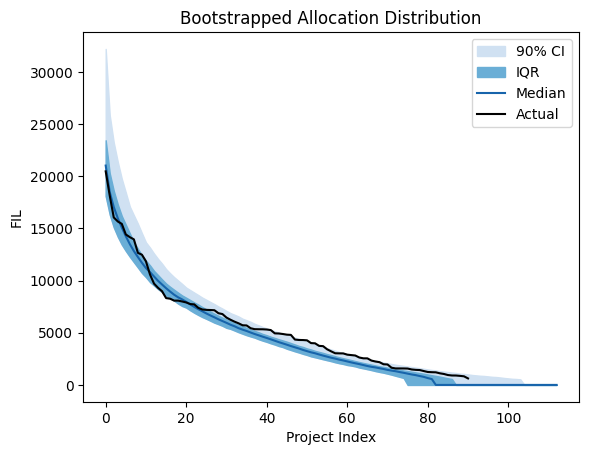

In [34]:
rpgf3lib.plot_bootstrap_distribution(
    bootstrap_allocations, 
    allocations, 
    save_fp='../figures/bootstrap_allocation_distribution.png'
)

In [35]:
success_df['PctOfTotal'] = success_df['Final Allocation (FIL)'] / success_df['Final Allocation (FIL)'].sum()*100
success_df.sort_values('PctOfTotal', ascending=False).head()
success_df.head()

,Project Name,Vote Count,Average Score,Std Dev,Final Allocation (FIL),category,PctOfTotal
81,Filecoin Onchain Cloud (FOC) - Verifiable Stor...,14,41332.00,35426.63,20461.54,Tooling & Utilities,4.01
42,FilOz - Advancing the Filecoin Protocol,17,30180.53,20082.92,18142.61,Protocol R&D,3.56
28,FIL-B (FIL Builders) DX and Community,15,30259.13,21604.06,16049.88,Edu & Outreach,3.15
22,go-libp2p,21,21087.95,19854.64,15659.49,Infra & Deps,3.07
64,Filecoin Data Portal,15,29094.80,27877.38,15432.30,Infra & Deps,3.03


In [36]:
xx = success_df.head()
xx['PctOfTotal'].sum()

np.float64(16.81290499989288)

In [37]:
success_df['Final Allocation (FIL)'].describe()


count      91.00
mean     5604.40
std      4371.43
min       622.99
25%      2211.85
50%      4815.74
75%      7550.22
max     20461.54
Name: Final Allocation (FIL), dtype: float64

In [38]:
success_df['Final Allocation (FIL)'].median()

np.float64(4815.73720406784)

In [39]:
success_df.sort_values('Vote Count', ascending=False).head()

,Project Name,Vote Count,Average Score,Std Dev,Final Allocation (FIL),category,PctOfTotal
22,go-libp2p,21,21087.95,19854.64,15659.49,Infra & Deps,3.07
88,Filscan Explorer,19,15750.05,14733.29,10581.80,Tooling & Utilities,2.07
42,FilOz - Advancing the Filecoin Protocol,17,30180.53,20082.92,18142.61,Protocol R&D,3.56
25,drand - the distributed randomness beacon proj...,16,25017.75,29742.05,14154.42,Infra & Deps,2.78
35,Chain.Love,16,13965.88,11046.84,7901.55,Infra & Deps,1.55


In [40]:
position_analysis_df = success_df[['Project Name', 'Vote Count', 'Final Allocation (FIL)']]
position_analysis_df['projects_alphabet_pos'] = position_analysis_df['Project Name'].apply(lambda x: ord(x.strip()[0].lower()) - ord('a'))

/tmp/ipykernel_446060/1574748377.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
def correlation_model_votes(x, y):
    # Priors for means and standard deviations of x and y
    mu_x = numpyro.sample('mu_x', dist.Normal(0, 10))
    sigma_x = numpyro.sample('sigma_x', dist.Exponential(1))
    
    mu_y = numpyro.sample('mu_y', dist.Normal(0, 10))
    sigma_y = numpyro.sample('sigma_y', dist.Exponential(1))
    
    # Prior for the correlation coefficient
    rho = numpyro.sample('rho', dist.Uniform(-1, 1))
    
    # Covariance matrix
    covariance = jnp.array([
        [sigma_x**2, rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2]
    ])
    
    # Sampling from a bivariate normal distribution
    numpyro.sample('obs', dist.MultivariateNormal(loc=jnp.array([mu_x, mu_y]), covariance_matrix=covariance), obs=jnp.column_stack((x, y)))

def correlation_model_allocation(x, y):
    # Adjust priors to match the scale of the data
    mu_x = numpyro.sample('mu_x', dist.Normal(np.mean(x), 10))
    sigma_x = numpyro.sample('sigma_x', dist.Exponential(1))
    
    # Use more appropriate priors for y given the scale of allocations
    mu_y = numpyro.sample('mu_y', dist.Normal(np.mean(y), 1000))  # Increased scale
    sigma_y = numpyro.sample('sigma_y', dist.Exponential(1000))  # Increased scale
    
    # Prior for the correlation coefficient
    rho = numpyro.sample('rho', dist.Uniform(-1, 1))
    
    # Covariance matrix
    covariance = jnp.array([
        [sigma_x**2, rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2]
    ])
    
    # Sampling from a bivariate normal distribution
    numpyro.sample('obs', dist.MultivariateNormal(loc=jnp.array([mu_x, mu_y]), covariance_matrix=covariance), obs=jnp.column_stack((x, y)))

In [42]:
nuts_kernel = NUTS(correlation_model_votes)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)

# Run MCMC
rng_key = random.PRNGKey(0)
x_data = position_analysis_df['projects_alphabet_pos'].values
y1_data = position_analysis_df['Vote Count'].values  # Use unsorted Vote Count
mcmc.run(rng_key, x=jnp.array(x_data), y=jnp.array(y1_data))

# mcmc.print_summary()
posterior_samples_votes = mcmc.get_samples()
rho_samples_votes = posterior_samples_votes['rho']

print(f"Modelled Pearson correlation coefficient of {np.mean(rho_samples_votes):.2f}")
print(f"With 95% credible intervals of the correlation coefficient being between {np.percentile(rho_samples_votes,5):.2f} and {np.percentile(rho_samples_votes,95):.2f}")

sample: 100%|██████████| 1500/1500 [00:00<00:00, 1568.63it/s, 3 steps of size 7.14e-01. acc. prob=0.92]


Modelled Pearson correlation coefficient of -0.05
With 95% credible intervals of the correlation coefficient being between -0.11 and 0.02


In [43]:
nuts_kernel = NUTS(correlation_model_allocation)
n_samples = 1000
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=n_samples)

# Run MCMC
rng_key = random.PRNGKey(0)
x_data = position_analysis_df['projects_alphabet_pos'].values
y2_data = position_analysis_df['Final Allocation (FIL)'].values  # Use unsorted Vote Count
mcmc.run(rng_key, x=jnp.array(x_data), y=jnp.array(y2_data))

# mcmc.print_summary()
posterior_samples_funding = mcmc.get_samples()
rho_samples_funding = posterior_samples_funding['rho']

print(f"Modelled Pearson correlation coefficient of {np.mean(rho_samples_funding):.2f}")
print(f"With 95% credible intervals of the correlation coefficient being between {np.percentile(rho_samples_funding,5):.2f} and {np.percentile(rho_samples_funding,95):.2f}")

sample: 100%|██████████| 1500/1500 [00:00<00:00, 1590.26it/s, 15 steps of size 3.47e-01. acc. prob=0.92]


Modelled Pearson correlation coefficient of -0.01
With 95% credible intervals of the correlation coefficient being between -0.01 and -0.00


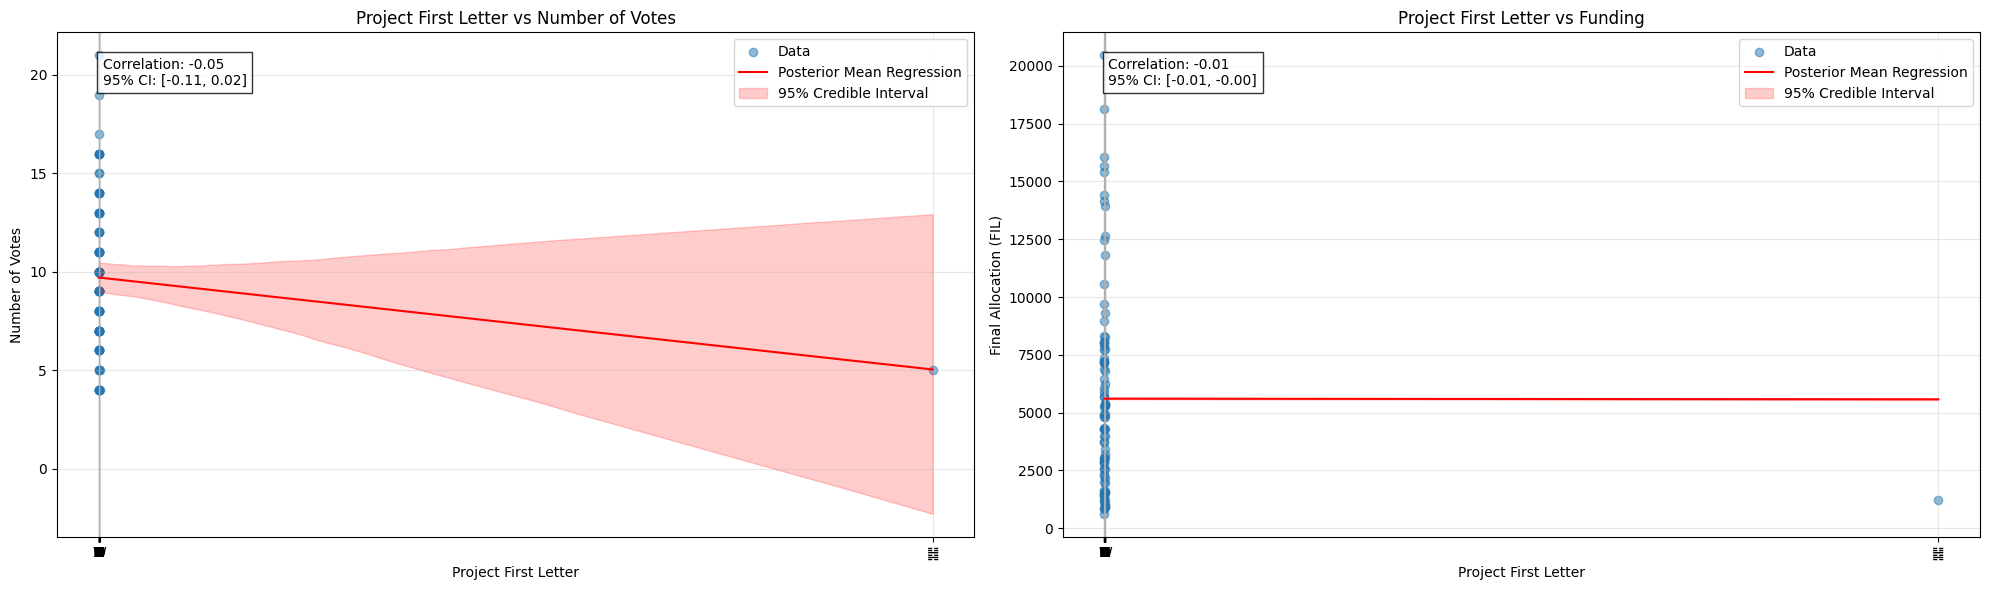

In [44]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Create letter labels for x-axis
unique_positions = sorted(position_analysis_df['projects_alphabet_pos'].unique())
letter_labels = [chr(int(pos) + ord('A')) for pos in unique_positions]

# Left plot - Votes
x_data = position_analysis_df['projects_alphabet_pos'].values
y1_data = position_analysis_df['Vote Count'].values

# Generate lines for votes plot
x_line = np.linspace(min(x_data), max(x_data), 100)
y1_lines = []
for i in range(n_samples):
    rho = posterior_samples_votes['rho'][i]
    mu_x = posterior_samples_votes['mu_x'][i]
    mu_y = posterior_samples_votes['mu_y'][i]
    sigma_x = posterior_samples_votes['sigma_x'][i]
    sigma_y = posterior_samples_votes['sigma_y'][i]
    
    beta = rho * sigma_y / sigma_x
    y = mu_y + beta * (x_line - mu_x)
    y1_lines.append(y)

y1_lines = np.array(y1_lines)
y1_mean = np.mean(y1_lines, axis=0)
y1_lower = np.percentile(y1_lines, 2.5, axis=0)
y1_upper = np.percentile(y1_lines, 97.5, axis=0)

# Plot votes
ax1.scatter(x_data, y1_data, alpha=0.5, label='Data')
ax1.plot(x_line, y1_mean, color='red', label='Posterior Mean Regression')
ax1.fill_between(x_line, y1_lower, y1_upper, color='red', alpha=0.2, label='95% Credible Interval')

correlation_text = (f"Correlation: {np.mean(posterior_samples_votes['rho']):.2f}\n"
                   f"95% CI: [{np.percentile(posterior_samples_votes['rho'],5):.2f}, "
                   f"{np.percentile(posterior_samples_votes['rho'],95):.2f}]")
ax1.text(0.05, 0.95, correlation_text, transform=ax1.transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')

ax1.set_xticks(unique_positions)
ax1.set_xticklabels(letter_labels)
ax1.set_xlabel('Project First Letter')
ax1.set_ylabel('Number of Votes')
ax1.set_title('Project First Letter vs Number of Votes')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right plot - Funding
y2_data = position_analysis_df['Final Allocation (FIL)'].values

# Generate lines for funding plot
y2_lines = []
for i in range(n_samples):
    rho = posterior_samples_funding['rho'][i]
    mu_x = posterior_samples_funding['mu_x'][i]
    mu_y = posterior_samples_funding['mu_y'][i]
    sigma_x = posterior_samples_funding['sigma_x'][i]
    sigma_y = posterior_samples_funding['sigma_y'][i]
    
    beta = rho * sigma_y / sigma_x
    y = mu_y + beta * (x_line - mu_x)
    y2_lines.append(y)

y2_lines = np.array(y2_lines)
y2_mean = np.mean(y2_lines, axis=0)
y2_lower = np.percentile(y2_lines, 2.5, axis=0)
y2_upper = np.percentile(y2_lines, 97.5, axis=0)

# Plot funding
ax2.scatter(x_data, y2_data, alpha=0.5, label='Data')
ax2.plot(x_line, y2_mean, color='red', label='Posterior Mean Regression')
ax2.fill_between(x_line, y2_lower, y2_upper, color='red', alpha=0.2, label='95% Credible Interval')

correlation_text = (f"Correlation: {np.mean(posterior_samples_funding['rho']):.2f}\n"
                   f"95% CI: [{np.percentile(posterior_samples_funding['rho'],5):.2f}, "
                   f"{np.percentile(posterior_samples_funding['rho'],95):.2f}]")
ax2.text(0.05, 0.95, correlation_text, transform=ax2.transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')

ax2.set_xticks(unique_positions)
ax2.set_xticklabels(letter_labels)
ax2.set_xlabel('Project First Letter')
ax2.set_ylabel('Final Allocation (FIL)')
ax2.set_title('Project First Letter vs Funding')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('../figures/project_letter_vs_votes_and_funding.png', dpi=300)